In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# ===================================================================
# CELDA 1: INSTALACIÓN DE DEPENDENCIAS
# ===================================================================
# Esta celda instala todas las librerías necesarias para el proyecto
# de aprendizaje por refuerzo con DDPG en el entorno Péndulo

import warnings
warnings.filterwarnings('ignore')  # Silenciar advertencias de dependencias

print("🔧 Instalando dependencias para RL con DDPG...")
print("⚠️  Los warnings de dependencias son normales en Kaggle y no afectan el funcionamiento")

# Instalar TF-Agents (framework principal de RL)
!pip install tf-agents[reverb] --quiet --no-warn-conflicts

# Instalar Gymnasium si es necesario (verificar versión)
try:
    import gymnasium
    print(f"✅ Gymnasium ya disponible (versión: {gymnasium.__version__})")
except ImportError:
    !pip install gymnasium --quiet --no-warn-conflicts
    print("✅ Gymnasium instalado")

# Instalar dependencias adicionales para visualización y video
!pip install imageio --quiet --no-warn-conflicts          # Para guardar videos
!pip install imageio-ffmpeg --quiet --no-warn-conflicts   # Codec para videos

# Verificar que matplotlib y pillow estén disponibles (vienen preinstalados en Kaggle)
try:
    import matplotlib
    import PIL
    print("✅ Matplotlib y Pillow ya disponibles")
except ImportError:
    !pip install matplotlib pillow --quiet --no-warn-conflicts

# Verificar instalación exitosa
print("\n🎯 ESTADO DE INSTALACIÓN")
print("="*40)
try:
    import tf_agents
    print("✅ TF-Agents: Instalado correctamente")
except ImportError:
    print("❌ TF-Agents: Error en instalación")

try:
    import gymnasium
    print("✅ Gymnasium: Disponible")
except ImportError:
    print("❌ Gymnasium: No disponible")

print("✅ Proyecto listo: Entrenamiento DDPG para Péndulo")
print("📋 Nota: Los warnings de dependencias no afectan el funcionamiento")

🔧 Instalando dependencias para RL con DDPG...
⚠️  Los warnings de dependencias son normales en Kaggle y no afectan el funcionamiento
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 9.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 71.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 73.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6

2025-06-27 19:41:38.731736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 19:41:38.731804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 19:41:38.733600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ TF-Agents: Instalado correctamente
✅ Gymnasium: Disponible
✅ Proyecto listo: Entrenamiento DDPG para Péndulo
📋 Nota: Los warnings de dependencias no afectan el funcionamiento


In [3]:
# ===================================================================
# CELDA 2: IMPORTACIÓN DE LIBRERÍAS
# ===================================================================
# Importamos todas las librerías necesarias para el proyecto

# Librerías básicas de Python
import numpy as np                    # Operaciones numéricas
import matplotlib.pyplot as plt       # Visualización de datos
import tensorflow as tf              # Framework de deep learning
import gymnasium as gym              # Entornos de RL (nueva versión de OpenAI Gym)
import imageio                       # Para crear videos
import os                           # Operaciones del sistema operativo
import time                         # Para medir tiempos de ejecución

# TF-Agents: Framework de aprendizaje por refuerzo
from tf_agents.agents.ddpg import ddpg_agent          # Agente DDPG
from tf_agents.agents.ddpg import actor_network       # Red Actor
from tf_agents.agents.ddpg import critic_network      # Red Critic
from tf_agents.drivers import dynamic_step_driver     # Driver para recolectar experiencias
from tf_agents.environments import suite_gym          # Wrapper para entornos Gym
from tf_agents.environments import tf_py_environment  # Wrapper TensorFlow
from tf_agents.eval import metric_utils               # Métricas de evaluación
from tf_agents.metrics import tf_metrics              # Métricas específicas de TF-Agents
from tf_agents.networks import actor_distribution_network  # Red de distribución
from tf_agents.policies import random_tf_policy       # Política aleatoria
from tf_agents.replay_buffers import tf_uniform_replay_buffer  # Buffer de experiencias
from tf_agents.trajectories import trajectory         # Trayectorias
from tf_agents.utils import common                    # Utilidades comunes

# Configurar TensorFlow para usar GPU si está disponible
print("🔍 Configurando TensorFlow...")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU disponible: {len(gpus)} dispositivo(s)")
    # Configurar crecimiento dinámico de memoria GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("⚠️  GPU no disponible, usando CPU")

# Verificar versiones
print(f"📦 TensorFlow version: {tf.__version__}")
print(f"📦 Gymnasium version: {gym.__version__}")
print("✅ Todas las librerías importadas correctamente")

🔍 Configurando TensorFlow...
⚠️  GPU no disponible, usando CPU
📦 TensorFlow version: 2.15.1
📦 Gymnasium version: 0.29.0
✅ Todas las librerías importadas correctamente


In [4]:
# ===================================================================
# CELDA 3: CONFIGURACIÓN DE HIPERPARÁMETROS
# ===================================================================
# Definimos todos los hiperparámetros para el entrenamiento DDPG

# Configuración del entorno
ENV_NAME = 'Pendulum-v1'              # Nombre del entorno de Gymnasium
NUM_ITERATIONS = 20000                # Número total de iteraciones de entrenamiento
INITIAL_COLLECT_STEPS = 500          # Pasos iniciales para llenar el replay buffer
COLLECT_STEPS_PER_ITERATION = 1       # Pasos de colección por iteración
REPLAY_BUFFER_MAX_LENGTH = 50000     # Tamaño máximo del replay buffer

# Configuración de la red neuronal
ACTOR_FC_LAYERS = (64, 32)            # Capas fully connected del Actor [64, 64]
CRITIC_OBS_FC_LAYERS = (64,)          # Capas FC del Critic para observaciones
CRITIC_ACTION_FC_LAYERS = (32,)       # Capas FC del Critic para acciones
CRITIC_JOINT_FC_LAYERS = (32,)        # Capas FC conjuntas del Critic

# Hiperparámetros de entrenamiento
LEARNING_RATE_ACTOR = 3e-4            # Tasa de aprendizaje del Actor
LEARNING_RATE_CRITIC = 1e-3           # Tasa de aprendizaje del Critic
BATCH_SIZE = 128                       # Tamaño del batch para entrenamiento
GAMMA = 0.99                          # Factor de descuento (discount factor)
TAU = 0.01                           # Tasa de actualización suave de target networks
TARGET_UPDATE_PERIOD = 1              # Frecuencia de actualización de target networks

# Configuración de exploración (ruido)
OU_STDDEV = 0.3                       # Desviación estándar del ruido Ornstein-Uhlenbeck
OU_DAMPING = 0.15                     # Factor de amortiguación del ruido OU
GRADIENT_CLIPPING = 0.5              # ACTIVADO para estabilidad

# Configuración de evaluación
NUM_EVAL_EPISODES = 5                # Número de episodios para evaluación
EVAL_INTERVAL = 2000                  # Intervalo de evaluación (cada N iteraciones)
LOG_INTERVAL = 500                    # Intervalo para mostrar logs (cada N iteraciones)

# Configuración de videos
VIDEO_INTERVAL = 5000                 # Intervalo para generar videos (cada N iteraciones)
VIDEO_LENGTH = 200                    # Duración de los videos en steps

# Configuración de checkpoints
CHECKPOINT_INTERVAL = 5000            # Intervalo para guardar checkpoints
CHECKPOINT_DIR = './checkpoints'      # Directorio para guardar checkpoints

# Crear directorio de checkpoints si no existe
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Mostrar configuración
print("⚙️  CONFIGURACIÓN DE HIPERPARÁMETROS")
print("="*50)
print(f"🎯 Entorno: {ENV_NAME}")
print(f"🔄 Iteraciones totales: {NUM_ITERATIONS:,}")
print(f"🧠 Arquitectura Actor: {ACTOR_FC_LAYERS}")
print(f"🧠 Arquitectura Critic: {CRITIC_OBS_FC_LAYERS} + {CRITIC_ACTION_FC_LAYERS} + {CRITIC_JOINT_FC_LAYERS}")
print(f"📚 Batch size: {BATCH_SIZE}")
print(f"📈 Learning rate Actor: {LEARNING_RATE_ACTOR}")
print(f"📈 Learning rate Critic: {LEARNING_RATE_CRITIC}")
print(f"🎲 Ruido OU std: {OU_STDDEV}")
print(f"💾 Replay buffer size: {REPLAY_BUFFER_MAX_LENGTH:,}")
print("✅ Configuración lista para entrenamiento")

⚙️  CONFIGURACIÓN DE HIPERPARÁMETROS
🎯 Entorno: Pendulum-v1
🔄 Iteraciones totales: 20,000
🧠 Arquitectura Actor: (64, 32)
🧠 Arquitectura Critic: (64,) + (32,) + (32,)
📚 Batch size: 128
📈 Learning rate Actor: 0.0003
📈 Learning rate Critic: 0.001
🎲 Ruido OU std: 0.3
💾 Replay buffer size: 50,000
✅ Configuración lista para entrenamiento


In [5]:
# ===================================================================
# CELDA 4: CONFIGURACIÓN DEL ENTORNO
# ===================================================================
# Creamos y configuramos el entorno Péndulo para TF-Agents

def create_pendulum_environment():
    """
    Crea y configura el entorno Péndulo para entrenamiento
    
    Returns:
        train_env: Entorno de entrenamiento
        eval_env: Entorno de evaluación
    """
    # Crear entorno base usando suite_gym (wrapper de TF-Agents para Gymnasium)
    train_py_env = suite_gym.load(ENV_NAME)  # Entorno Python para entrenamiento
    eval_py_env = suite_gym.load(ENV_NAME)   # Entorno Python para evaluación
    
    # Convertir a entornos TensorFlow (necesario para TF-Agents)
    train_env = tf_py_environment.TFPyEnvironment(train_py_env)
    eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
    
    return train_env, eval_env

# Crear los entornos
print("🏗️  Creando entornos...")
train_env, eval_env = create_pendulum_environment()

# Examinar las especificaciones del entorno
print("📊 ESPECIFICACIONES DEL ENTORNO PÉNDULO")
print("="*50)

# Espacio de observación
obs_spec = train_env.observation_spec()
print(f"🔍 Observaciones:")
print(f"   - Forma: {obs_spec.shape}")
print(f"   - Tipo: {obs_spec.dtype}")
print(f"   - Rango: [{obs_spec.minimum}, {obs_spec.maximum}]")

# Espacio de acción
action_spec = train_env.action_spec()
print(f"🎮 Acciones:")
print(f"   - Forma: {action_spec.shape}")
print(f"   - Tipo: {action_spec.dtype}")
print(f"   - Rango: [{action_spec.minimum}, {action_spec.maximum}]")

# Especificación de time_step
time_step_spec = train_env.time_step_spec()
print(f"⏰ Time Step:")
print(f"   - Reward shape: {time_step_spec.reward.shape}")
print(f"   - Reward dtype: {time_step_spec.reward.dtype}")

# Probar el entorno con acciones aleatorias
print("\n🎲 Probando entorno con acción aleatoria...")
time_step = train_env.reset()
print(f"   - Observación inicial: {time_step.observation.numpy()}")

# Ejecutar una acción aleatoria
random_action = tf.random.uniform(action_spec.shape, 
                                 action_spec.minimum, 
                                 action_spec.maximum)
time_step = train_env.step(tf.expand_dims(random_action, 0))
print(f"   - Reward obtenido: {time_step.reward.numpy()}")
print(f"   - Nueva observación: {time_step.observation.numpy()}")

print("✅ Entorno configurado correctamente")

# Información adicional sobre el péndulo
print("\n📚 INFORMACIÓN DEL ENTORNO PÉNDULO")
print("="*50)
print("🎯 Objetivo: Mantener el péndulo en posición vertical (θ = 0)")
print("📐 Observaciones:")
print("   - cos(θ): Coseno del ángulo del péndulo")
print("   - sin(θ): Seno del ángulo del péndulo") 
print("   - θ_dot: Velocidad angular del péndulo")
print("🎮 Acciones:")
print("   - Torque aplicado al péndulo (continuo: -2.0 a +2.0)")
print("🏆 Recompensa:")
print("   - r = -(θ² + 0.1*θ_dot² + 0.001*torque²)")
print("   - Máxima recompensa teórica: 0 (péndulo estático en vertical)")

🏗️  Creando entornos...
📊 ESPECIFICACIONES DEL ENTORNO PÉNDULO
🔍 Observaciones:
   - Forma: (3,)
   - Tipo: <dtype: 'float32'>
   - Rango: [[-1. -1. -8.], [1. 1. 8.]]
🎮 Acciones:
   - Forma: (1,)
   - Tipo: <dtype: 'float32'>
   - Rango: [-2.0, 2.0]
⏰ Time Step:
   - Reward shape: ()
   - Reward dtype: <dtype: 'float32'>

🎲 Probando entorno con acción aleatoria...
   - Observación inicial: [[-0.97978884 -0.20003453  0.1923303 ]]
   - Reward obtenido: [-8.648473]
   - Nueva observación: [[-0.9793844  -0.20200534  0.04023775]]
✅ Entorno configurado correctamente

📚 INFORMACIÓN DEL ENTORNO PÉNDULO
🎯 Objetivo: Mantener el péndulo en posición vertical (θ = 0)
📐 Observaciones:
   - cos(θ): Coseno del ángulo del péndulo
   - sin(θ): Seno del ángulo del péndulo
   - θ_dot: Velocidad angular del péndulo
🎮 Acciones:
   - Torque aplicado al péndulo (continuo: -2.0 a +2.0)
🏆 Recompensa:
   - r = -(θ² + 0.1*θ_dot² + 0.001*torque²)
   - Máxima recompensa teórica: 0 (péndulo estático en vertical)


In [6]:
# ===================================================================
# CELDA 5: DEFINICIÓN DE REDES NEURONALES (ACTOR Y CRITIC)
# ===================================================================
# Creamos las arquitecturas de redes neuronales para el algoritmo DDPG

def create_actor_network(train_env):
    """
    Crea la red Actor para DDPG
    
    La red Actor mapea observaciones a acciones continuas
    Input: observaciones del entorno (cos(θ), sin(θ), θ_dot)
    Output: acción continua (torque)
    
    Args:
        train_env: Entorno de entrenamiento
        
    Returns:
        actor_net: Red neuronal del Actor
    """
    # Crear red Actor usando actor_network de TF-Agents
    actor_net = actor_network.ActorNetwork(
        # Especificaciones de entrada (observaciones)
        train_env.observation_spec(),
        
        # Especificaciones de salida (acciones)
        train_env.action_spec(),
        
        # Capas fully connected (densas) del Actor
        fc_layer_params=ACTOR_FC_LAYERS,  # (64, 32) neuronas por capa - OPTIMIZADO
        
        # Función de activación para capas ocultas
        activation_fn=tf.keras.activations.relu,  # ReLU para capas ocultas
        
        # Nombre de la red para debugging
        name='ActorNetwork'
    )
    
    return actor_net

def create_critic_network(train_env):
    """
    Crea la red Critic para DDPG
    
    La red Critic estima el Q-value de un par (estado, acción)
    Input: observaciones + acciones
    Output: Q-value escalar
    
    Args:
        train_env: Entorno de entrenamiento
        
    Returns:
        critic_net: Red neuronal del Critic
    """
    # Crear red Critic usando critic_network de TF-Agents
    critic_net = critic_network.CriticNetwork(
        # Especificaciones de entrada (observaciones, acciones)
        (train_env.observation_spec(), train_env.action_spec()),
        
        # Capas FC para procesar observaciones por separado
        observation_fc_layer_params=CRITIC_OBS_FC_LAYERS,  # (64,)
        
        # Capas FC para procesar acciones por separado  
        action_fc_layer_params=CRITIC_ACTION_FC_LAYERS,    # (32,) - OPTIMIZADO
        
        # Capas FC conjuntas (después de concatenar obs + acciones)
        joint_fc_layer_params=CRITIC_JOINT_FC_LAYERS,      # (32,) - OPTIMIZADO
        
        # Función de activación para capas ocultas
        activation_fn=tf.keras.activations.relu,
        
        # Sin activación en la salida (Q-value puede ser cualquier valor real)
        output_activation_fn=None,
        
        # Nombre de la red para debugging
        name='CriticNetwork'
    )
    
    return critic_net

def print_network_summary():
    """
    ⚡ FUNCIÓN NUEVA: Muestra un resumen optimizado de las redes para verificar eficiencia
    
    Calcula el número aproximado de parámetros de cada red y proporciona
    información sobre la eficiencia de la configuración actual.
    """
    # Calcular parámetros aproximados del Actor
    # Input layer: 3 observaciones → 64 neuronas = 3*64 + 64 (bias) = 256
    # Hidden layer: 64 → 32 = 64*32 + 32 = 2080  
    # Output layer: 32 → 1 acción = 32*1 + 1 = 33
    actor_params = (3 * 64 + 64) + (64 * 32 + 32) + (32 * 1 + 1)
    
    # Calcular parámetros aproximados del Critic
    # Obs branch: 3 → 64 = 3*64 + 64 = 256
    # Action branch: 1 → 32 = 1*32 + 32 = 64
    # Joint branch: (64+32) → 32 → 1 = 96*32 + 32 + 32*1 + 1 = 3105
    critic_params = (3 * 64 + 64) + (1 * 32 + 32) + (96 * 32 + 32) + (32 * 1 + 1)
    
    total_params = actor_params + critic_params
    
    print(f"\n📊 RESUMEN DE EFICIENCIA DE LAS REDES:")
    print("="*50)
    print(f"🎭 Red Actor:")
    print(f"   - Parámetros: ~{actor_params:,}")
    print(f"   - Arquitectura: 3 → {ACTOR_FC_LAYERS[0]} → {ACTOR_FC_LAYERS[1]} → 1")
    print(f"🔍 Red Critic:")
    print(f"   - Parámetros: ~{critic_params:,}")
    print(f"   - Obs branch: 3 → {CRITIC_OBS_FC_LAYERS[0]}")
    print(f"   - Action branch: 1 → {CRITIC_ACTION_FC_LAYERS[0]}")
    print(f"   - Joint branch: {CRITIC_OBS_FC_LAYERS[0] + CRITIC_ACTION_FC_LAYERS[0]} → {CRITIC_JOINT_FC_LAYERS[0]} → 1")
    print(f"📈 Total de parámetros: ~{total_params:,}")
    print(f"⚡ Configuración: OPTIMIZADA para entrenamiento rápido")
    print(f"🚀 Tiempo estimado: 15-20 minutos de entrenamiento")

# ===================================================================
# CREAR Y PROBAR LAS REDES NEURONALES
# ===================================================================

print("🧠 Creando redes neuronales...")

# Red Actor: observaciones → acciones
actor_net = create_actor_network(train_env)
print(f"✅ Red Actor creada:")
print(f"   - Input: {train_env.observation_spec().shape} (observaciones)")
print(f"   - Output: {train_env.action_spec().shape} (acciones)")
print(f"   - Arquitectura: {ACTOR_FC_LAYERS} + activación tanh")

# Red Critic: (observaciones, acciones) → Q-value
critic_net = create_critic_network(train_env)
print(f"✅ Red Critic creada:")
print(f"   - Input obs: {train_env.observation_spec().shape}")
print(f"   - Input action: {train_env.action_spec().shape}")
print(f"   - Output: Q-value escalar")
print(f"   - Arquitectura obs: {CRITIC_OBS_FC_LAYERS}")
print(f"   - Arquitectura action: {CRITIC_ACTION_FC_LAYERS}")
print(f"   - Arquitectura joint: {CRITIC_JOINT_FC_LAYERS}")

# Probar las redes con datos de ejemplo
print("\n🔍 Probando las redes con datos de ejemplo...")

# Crear observación y acción de ejemplo
sample_time_step = train_env.reset()
sample_observation = sample_time_step.observation
sample_action = tf.random.uniform(train_env.action_spec().shape,
                                 train_env.action_spec().minimum,
                                 train_env.action_spec().maximum)

# Probar red Actor
actor_output, _ = actor_net(sample_observation, step_type=sample_time_step.step_type)
print(f"📤 Salida del Actor: {actor_output.numpy()}")
print(f"   - Rango esperado: [{train_env.action_spec().minimum}, {train_env.action_spec().maximum}]")

# Probar red Critic
critic_output, _ = critic_net((sample_observation, sample_action), 
                             step_type=sample_time_step.step_type)
print(f"📊 Salida del Critic (Q-value): {critic_output.numpy()}")

print("✅ Redes neuronales configuradas y probadas correctamente")

# ===================================================================
# NUEVA FUNCIÓN: MOSTRAR RESUMEN DE EFICIENCIA
# ===================================================================
print_network_summary()

🧠 Creando redes neuronales...
✅ Red Actor creada:
   - Input: (3,) (observaciones)
   - Output: (1,) (acciones)
   - Arquitectura: (64, 32) + activación tanh
✅ Red Critic creada:
   - Input obs: (3,)
   - Input action: (1,)
   - Output: Q-value escalar
   - Arquitectura obs: (64,)
   - Arquitectura action: (32,)
   - Arquitectura joint: (32,)

🔍 Probando las redes con datos de ejemplo...
📤 Salida del Actor: [[-0.00118755]]
   - Rango esperado: [-2.0, 2.0]
📊 Salida del Critic (Q-value): [-0.00102708]
✅ Redes neuronales configuradas y probadas correctamente

📊 RESUMEN DE EFICIENCIA DE LAS REDES:
🎭 Red Actor:
   - Parámetros: ~2,369
   - Arquitectura: 3 → 64 → 32 → 1
🔍 Red Critic:
   - Parámetros: ~3,457
   - Obs branch: 3 → 64
   - Action branch: 1 → 32
   - Joint branch: 96 → 32 → 1
📈 Total de parámetros: ~5,826
⚡ Configuración: OPTIMIZADA para entrenamiento rápido
🚀 Tiempo estimado: 15-20 minutos de entrenamiento


In [7]:
# ===================================================================
# CELDA 6: CONFIGURACIÓN DEL REPLAY BUFFER
# ===================================================================
# El replay buffer almacena experiencias (s, a, r, s') para entrenar el agente
# Permite aprendizaje fuera de línea (off-policy) y rompe correlaciones temporales

# Importar la clase para el replay buffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer

def create_replay_buffer(data_spec, batch_size, max_length):
    """
    Crea un buffer de replay uniforme para almacenar experiencias
    
    El replay buffer es una estructura de datos circular que:
    - Almacena tuplas (observación, acción, recompensa, nueva_observación)
    - Permite muestreo aleatorio para romper correlaciones temporales
    - Sobrescribe experiencias antiguas cuando se llena (FIFO)
    
    Args:
        data_spec: Especificación del formato de datos a almacenar
        batch_size: Tamaño del batch para muestreo
        max_length: Número máximo de experiencias a almacenar
        
    Returns:
        replay_buffer: Buffer de replay configurado
    """
    # Crear buffer de replay uniforme de TF-Agents
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        # Especificación de los datos que almacenará (trajectory format)
        data_spec=data_spec,
        
        # Tamaño del batch cuando muestreemos experiencias
        batch_size=batch_size,
        
        # Capacidad máxima del buffer (más antiguas se eliminan)
        max_length=max_length
    )
    
    return replay_buffer

# ===================================================================
# CREAR EL REPLAY BUFFER
# ===================================================================

print("💾 Configurando Replay Buffer...")

# Primero necesitamos crear un agente temporal para obtener la especificación de datos
# Esto es necesario porque el replay buffer necesita saber qué formato de datos almacenar
from tf_agents.agents.ddpg import ddpg_agent

# Crear optimizadores temporales para el agente (solo para obtener data_spec)
temp_actor_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ACTOR)
temp_critic_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_CRITIC)

# Crear agente temporal para obtener especificación de datos
temp_agent = ddpg_agent.DdpgAgent(
    # Especificaciones de tiempo, observación y acción del entorno
    train_env.time_step_spec(),
    train_env.action_spec(),
    
    # Redes neuronales que creamos anteriormente
    actor_network=actor_net,
    critic_network=critic_net,
    
    # Optimizadores para Actor y Critic
    actor_optimizer=temp_actor_optimizer,
    critic_optimizer=temp_critic_optimizer,
    
    # Hiperparámetros del algoritmo DDPG
    target_update_tau=TAU,           # Tasa de actualización suave (soft update)
    target_update_period=TARGET_UPDATE_PERIOD,  # Frecuencia de actualización
    gamma=GAMMA,                     # Factor de descuento
    gradient_clipping=GRADIENT_CLIPPING,  # Clipping de gradientes
    
    # Configuración del entrenamiento
    train_step_counter=tf.Variable(0)  # Contador de pasos de entrenamiento
)

# Inicializar el agente temporal
temp_agent.initialize()

print(f"✅ Agente temporal creado para obtener especificación de datos")

# Obtener la especificación de datos del agente (formato de experiencias)
# Esto define qué información se almacenará en cada experiencia del buffer
data_spec = temp_agent.collect_data_spec

print(f"📋 Especificación de datos obtenida:")
print(f"   - Formato: {type(data_spec).__name__}")
print(f"   - Incluye: observación, acción, recompensa, siguiente_observación, etc.")

# ===================================================================
# CREAR EL REPLAY BUFFER PRINCIPAL
# ===================================================================

# Crear el replay buffer usando los hiperparámetros definidos
replay_buffer = create_replay_buffer(
    data_spec=data_spec,                          # Formato de datos a almacenar
    batch_size=train_env.batch_size,              # Batch size del entorno
    max_length=REPLAY_BUFFER_MAX_LENGTH           # Capacidad máxima (50,000)
)

print(f"💾 Replay Buffer creado exitosamente:")
print(f"   - Capacidad máxima: {REPLAY_BUFFER_MAX_LENGTH:,} experiencias")
print(f"   - Batch size: {train_env.batch_size}")
print(f"   - Tipo de buffer: Uniforme (muestreo aleatorio)")
print(f"   - Política de sobrescritura: FIFO (First In, First Out)")

# ===================================================================
# FUNCIONES AUXILIARES PARA EL REPLAY BUFFER
# ===================================================================

def get_buffer_info(buffer):
    """
    Obtiene información del estado actual del replay buffer
    
    Args:
        buffer: El replay buffer a inspeccionar
        
    Returns:
        dict: Información del buffer (tamaño actual, capacidad, etc.)
    """
    try:
        # Obtener número actual de elementos en el buffer
        current_size = buffer.num_frames().numpy()
        max_capacity = buffer._max_length
        fill_percentage = (current_size / max_capacity) * 100 if max_capacity > 0 else 0
        
        return {
            'current_size': current_size,
            'max_capacity': max_capacity,
            'fill_percentage': fill_percentage,
            'is_ready_for_training': current_size >= BATCH_SIZE
        }
    except:
        # Si hay error, devolver valores por defecto
        return {
            'current_size': 0,
            'max_capacity': REPLAY_BUFFER_MAX_LENGTH,
            'fill_percentage': 0.0,
            'is_ready_for_training': False
        }

def print_buffer_status():
    """
    Imprime el estado actual del replay buffer de forma legible
    """
    info = get_buffer_info(replay_buffer)
    
    print(f"\n📊 ESTADO DEL REPLAY BUFFER:")
    print(f"   - Experiencias almacenadas: {info['current_size']:,}")
    print(f"   - Capacidad máxima: {info['max_capacity']:,}")
    print(f"   - Porcentaje de llenado: {info['fill_percentage']:.1f}%")
    print(f"   - Listo para entrenamiento: {'✅ Sí' if info['is_ready_for_training'] else '❌ No'}")
    
    if not info['is_ready_for_training']:
        needed = BATCH_SIZE - info['current_size']
        print(f"   - Experiencias faltantes: {needed} (mínimo para batch: {BATCH_SIZE})")

# Mostrar estado inicial del buffer
print_buffer_status()

print("✅ Replay Buffer configurado y listo para almacenar experiencias")
print(f"🎯 Próximo paso: Configurar políticas y métricas (Celda 7)")



💾 Configurando Replay Buffer...
✅ Agente temporal creado para obtener especificación de datos
📋 Especificación de datos obtenida:
   - Formato: Trajectory
   - Incluye: observación, acción, recompensa, siguiente_observación, etc.
💾 Replay Buffer creado exitosamente:
   - Capacidad máxima: 50,000 experiencias
   - Batch size: 1
   - Tipo de buffer: Uniforme (muestreo aleatorio)
   - Política de sobrescritura: FIFO (First In, First Out)

📊 ESTADO DEL REPLAY BUFFER:
   - Experiencias almacenadas: 0
   - Capacidad máxima: 50,000
   - Porcentaje de llenado: 0.0%
   - Listo para entrenamiento: ❌ No
   - Experiencias faltantes: 128 (mínimo para batch: 128)
✅ Replay Buffer configurado y listo para almacenar experiencias
🎯 Próximo paso: Configurar políticas y métricas (Celda 7)


In [8]:
# ===================================================================
# CELDA 7: CONFIGURACIÓN DE POLÍTICAS Y MÉTRICAS
# ===================================================================
# Las políticas definen cómo el agente selecciona acciones en diferentes situaciones
# Las métricas nos permiten monitorear el progreso del entrenamiento

# Importar módulos necesarios para políticas y métricas
from tf_agents.policies import random_tf_policy
from tf_agents.policies import ou_noise_policy
from tf_agents.metrics import tf_metrics
from tf_agents.eval import metric_utils
from tf_agents.drivers import dynamic_step_driver
import numpy as np

# ===================================================================
# CREAR EL AGENTE DDPG PRINCIPAL
# ===================================================================

print("🤖 Creando agente DDPG principal...")

# Crear optimizadores con las tasas de aprendizaje configuradas
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ACTOR)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_CRITIC)

# Crear el agente DDPG principal que se usará para el entrenamiento
agent = ddpg_agent.DdpgAgent(
    # Especificaciones del entorno (tiempo, observación, acción)
    train_env.time_step_spec(),
    train_env.action_spec(),
    
    # Redes neuronales Actor y Critic que creamos anteriormente
    actor_network=actor_net,
    critic_network=critic_net,
    
    # Optimizadores para entrenar cada red
    actor_optimizer=actor_optimizer,
    critic_optimizer=critic_optimizer,
    
    # Parámetros del algoritmo DDPG
    target_update_tau=TAU,                    # Tasa de actualización suave (0.01)
    target_update_period=TARGET_UPDATE_PERIOD, # Frecuencia de actualización (1)
    gamma=GAMMA,                              # Factor de descuento (0.99)
    gradient_clipping=GRADIENT_CLIPPING,      # Clipping de gradientes (0.5)
    
    # Contador de pasos de entrenamiento
    train_step_counter=tf.Variable(0),
    
    # Configuración de debugging
    debug_summaries=False,  # No crear logs detallados (más rápido)
    summarize_grads_and_vars=False  # No resumir gradientes (más rápido)
)

# Inicializar el agente (crear variables internas)
agent.initialize()

print("✅ Agente DDPG principal creado e inicializado")

# ===================================================================
# CONFIGURAR POLÍTICAS
# ===================================================================

print("🎯 Configurando políticas...")

# 1. POLÍTICA DE ENTRENAMIENTO (con ruido para exploración)
# ✅ SINTAXIS CORREGIDA: Usar wrapped_policy en lugar de policy
collect_policy = ou_noise_policy.OUNoisePolicy(
    # CORREGIDO: usar wrapped_policy en lugar de policy
    wrapped_policy=agent.collect_policy,
    
    # Parámetros del ruido Ornstein-Uhlenbeck
    ou_stddev=OU_STDDEV,        # Desviación estándar del ruido (0.3)
    ou_damping=OU_DAMPING,      # Factor de amortiguación (0.15)
    
    # Clipping del ruido para mantenerlo en rango válido
    clip=True  # Asegurar que acciones estén en el rango permitido
)

print(f"✅ Política de entrenamiento (con ruido OU):")
print(f"   - Desviación estándar: {OU_STDDEV}")
print(f"   - Factor de amortiguación: {OU_DAMPING}")
print(f"   - Clipping activado: Sí")

# 2. POLÍTICA DE EVALUACIÓN (sin ruido, determinística)
# Se usa para evaluar el rendimiento real del agente
eval_policy = agent.policy

print(f"✅ Política de evaluación (determinística):")
print(f"   - Sin ruido añadido")
print(f"   - Acciones basadas únicamente en la red Actor")

# 3. POLÍTICA ALEATORIA (para comparación)
# Política completamente aleatoria para generar video de comparación
random_policy = random_tf_policy.RandomTFPolicy(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec()
)

print(f"✅ Política aleatoria creada para comparación")

# ===================================================================
# CONFIGURAR MÉTRICAS DE EVALUACIÓN
# ===================================================================

print("📊 Configurando métricas de evaluación...")

# Lista de métricas para monitorear el progreso del entrenamiento
eval_metrics = [
    # Métrica principal: Retorno promedio por episodio
    tf_metrics.AverageReturnMetric(
        name='AverageReturn',           # Nombre de la métrica
        buffer_size=NUM_EVAL_EPISODES   # Promediar sobre N episodios
    ),
    
    # Métrica secundaria: Longitud promedio de episodios
    tf_metrics.AverageEpisodeLengthMetric(
        name='AverageEpisodeLength',    # Nombre de la métrica
        buffer_size=NUM_EVAL_EPISODES   # Promediar sobre N episodios
    ),
    
    # Métrica de diagnóstico: Número de episodios evaluados
    tf_metrics.NumberOfEpisodes(
        name='NumberOfEpisodes'         # Contador de episodios
    ),
    
    # Métrica de diagnóstico: Pasos de entorno ejecutados
    tf_metrics.EnvironmentSteps(
        name='EnvironmentSteps'         # Contador de pasos
    )
]

print(f"✅ Métricas configuradas:")
for i, metric in enumerate(eval_metrics, 1):
    print(f"   {i}. {metric.name}")

# ===================================================================
# CREAR DRIVER DE EVALUACIÓN
# ===================================================================

print("🏃 Configurando driver de evaluación...")

# El driver ejecuta la política en el entorno y recolecta métricas
eval_driver = dynamic_step_driver.DynamicStepDriver(
    # Entorno de evaluación
    env=eval_env,
    
    # Política determinística (sin ruido)
    policy=eval_policy,
    
    # Métricas a calcular durante la evaluación
    observers=eval_metrics,
    
    # Número de pasos a ejecutar por evaluación
    num_steps=NUM_EVAL_EPISODES * 200  # ~200 pasos por episodio promedio
)

print(f"✅ Driver de evaluación creado:")
print(f"   - Pasos por evaluación: {NUM_EVAL_EPISODES * 200}")
print(f"   - Política: Determinística")
print(f"   - Métricas: {len(eval_metrics)} configuradas")

# ===================================================================
# FUNCIONES AUXILIARES PARA MÉTRICAS
# ===================================================================

def reset_metrics():
    """
    Reinicia todas las métricas de evaluación
    Útil para comenzar una nueva evaluación limpia
    """
    for metric in eval_metrics:
        metric.reset()
    print("🔄 Métricas reiniciadas")

def get_current_metrics():
    """
    Obtiene los valores actuales de todas las métricas
    
    Returns:
        dict: Diccionario con nombre_métrica: valor
    """
    metrics_dict = {}
    for metric in eval_metrics:
        try:
            # Obtener resultado de la métrica
            result = metric.result()
            
            # Convertir a numpy si es tensor
            if hasattr(result, 'numpy'):
                value = result.numpy()
            else:
                value = result
                
            metrics_dict[metric.name] = value
        except:
            # Si hay error, usar valor por defecto
            metrics_dict[metric.name] = 0.0
    
    return metrics_dict

def print_current_metrics():
    """
    Imprime las métricas actuales de forma legible
    """
    metrics = get_current_metrics()
    
    print(f"\n📊 MÉTRICAS ACTUALES:")
    print(f"   🏆 Retorno promedio: {metrics.get('AverageReturn', 0):.2f}")
    print(f"   ⏱️  Longitud promedio: {metrics.get('AverageEpisodeLength', 0):.1f} pasos")
    print(f"   🎮 Episodios evaluados: {metrics.get('NumberOfEpisodes', 0)}")
    print(f"   👟 Pasos de entorno: {metrics.get('EnvironmentSteps', 0)}")

# ===================================================================
# FUNCIÓN DE EVALUACIÓN COMPLETA
# ===================================================================

def evaluate_agent(step_number=0):
    """
    Ejecuta una evaluación completa del agente
    
    Args:
        step_number: Número de paso actual del entrenamiento
        
    Returns:
        float: Retorno promedio obtenido
    """
    print(f"\n🔍 Evaluando agente (paso {step_number})...")
    
    # Reiniciar métricas para nueva evaluación
    reset_metrics()
    
    # Ejecutar el driver de evaluación
    eval_driver.run()
    
    # Obtener métricas resultantes
    metrics = get_current_metrics()
    avg_return = metrics.get('AverageReturn', 0)
    
    # Mostrar resultados
    print_current_metrics()
    
    return avg_return

# ===================================================================
# VERIFICACIÓN DE POLÍTICAS
# ===================================================================

print("🧪 Verificando políticas...")

# Crear un time_step de ejemplo para probar las políticas
sample_time_step = train_env.reset()

# Probar política de entrenamiento (con ruido)
collect_action = collect_policy.action(sample_time_step)
print(f"📤 Acción de entrenamiento (con ruido): {collect_action.action.numpy()}")

# Probar política de evaluación (sin ruido)
eval_action = eval_policy.action(sample_time_step)
print(f"📤 Acción de evaluación (sin ruido): {eval_action.action.numpy()}")

# Probar política aleatoria
random_action = random_policy.action(sample_time_step)
print(f"📤 Acción aleatoria: {random_action.action.numpy()}")

print("✅ Políticas y métricas configuradas correctamente")
print(f"🎯 Próximo paso: Configurar loop de entrenamiento (Celda 8)")

🤖 Creando agente DDPG principal...
✅ Agente DDPG principal creado e inicializado
🎯 Configurando políticas...
✅ Política de entrenamiento (con ruido OU):
   - Desviación estándar: 0.3
   - Factor de amortiguación: 0.15
   - Clipping activado: Sí
✅ Política de evaluación (determinística):
   - Sin ruido añadido
   - Acciones basadas únicamente en la red Actor
✅ Política aleatoria creada para comparación
📊 Configurando métricas de evaluación...
✅ Métricas configuradas:
   1. AverageReturn
   2. AverageEpisodeLength
   3. NumberOfEpisodes
   4. EnvironmentSteps
🏃 Configurando driver de evaluación...
✅ Driver de evaluación creado:
   - Pasos por evaluación: 1000
   - Política: Determinística
   - Métricas: 4 configuradas
🧪 Verificando políticas...
📤 Acción de entrenamiento (con ruido): [[0.24671952]]
📤 Acción de evaluación (sin ruido): [[-0.0040132]]
📤 Acción aleatoria: [[-1.7510796]]
✅ Políticas y métricas configuradas correctamente
🎯 Próximo paso: Configurar loop de entrenamiento (Celda 8

In [9]:
# ===================================================================
# CELDA 8: CONFIGURACIÓN DEL REPLAY BUFFER Y DRIVERS
# ===================================================================
# El replay buffer almacena experiencias pasadas para entrenar el agente
# Los drivers ejecutan políticas en el entorno y recolectan datos

print("💾 Configurando Replay Buffer y Drivers...")

# ===================================================================
# CONFIGURAR REPLAY BUFFER
# ===================================================================

# El replay buffer almacena tuplas (estado, acción, recompensa, siguiente_estado)
# DDPG necesita este buffer para aprender de experiencias pasadas
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    # Especificación de los datos que se almacenarán
    data_spec=agent.collect_data_spec,
    
    # Tamaño del batch para entrenar
    batch_size=train_env.batch_size,
    
    # Capacidad máxima del buffer (50,000 experiencias)
    max_length=REPLAY_BUFFER_MAX_LENGTH
)

print(f"✅ Replay Buffer configurado:")
print(f"   - Capacidad máxima: {REPLAY_BUFFER_MAX_LENGTH:,} experiencias")
print(f"   - Batch size: {train_env.batch_size}")

# ===================================================================
# CONFIGURAR DRIVER DE RECOLECCIÓN INICIAL
# ===================================================================

# Driver para llenar el replay buffer con experiencias iniciales
# Usa política aleatoria para exploración inicial diversa
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    # Entorno de entrenamiento
    env=train_env,
    
    # Política aleatoria para exploración inicial
    policy=random_policy,
    
    # Observer que guarda experiencias en el replay buffer
    observers=[replay_buffer.add_batch],
    
    # Número de pasos para recolección inicial
    num_steps=INITIAL_COLLECT_STEPS
)

print(f"✅ Driver de recolección inicial:")
print(f"   - Pasos iniciales: {INITIAL_COLLECT_STEPS}")
print(f"   - Política: Aleatoria (para diversidad)")

# ===================================================================
# CONFIGURAR DRIVER DE RECOLECCIÓN PARA ENTRENAMIENTO
# ===================================================================

# Driver para recolectar experiencias durante el entrenamiento
# Usa la política de entrenamiento (con ruido OU)
collect_driver = dynamic_step_driver.DynamicStepDriver(
    # Entorno de entrenamiento
    env=train_env,
    
    # Política de entrenamiento (con ruido para exploración)
    policy=collect_policy,
    
    # Observer que guarda experiencias en el replay buffer
    observers=[replay_buffer.add_batch],
    
    # Pasos por iteración de entrenamiento
    num_steps=COLLECT_STEPS_PER_ITERATION
)

print(f"✅ Driver de recolección para entrenamiento:")
print(f"   - Pasos por iteración: {COLLECT_STEPS_PER_ITERATION}")
print(f"   - Política: DDPG con ruido OU")

# ===================================================================
# CONFIGURAR DATASET PARA ENTRENAMIENTO
# ===================================================================

# Crear dataset de TensorFlow a partir del replay buffer
# Este dataset alimentará el entrenamiento del agente
dataset = replay_buffer.as_dataset(
    # Número de trayectorias paralelas a muestrear
    num_parallel_calls=tf.data.AUTOTUNE,
    
    # Tamaño de muestra del buffer
    sample_batch_size=BATCH_SIZE,
    
    # Número de pasos por trayectoria (2 para DDPG: estado actual y siguiente)
    num_steps=2
).prefetch(tf.data.AUTOTUNE)

print(f"✅ Dataset de entrenamiento configurado:")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Pasos por trayectoria: 2")
print(f"   - Optimización: AUTOTUNE")

# Crear iterador del dataset
dataset_iterator = iter(dataset)

print(f"✅ Iterador del dataset creado")

# ===================================================================
# FUNCIONES AUXILIARES PARA EL REPLAY BUFFER
# ===================================================================

def get_buffer_info():
    """
    Obtiene información actual del replay buffer
    
    Returns:
        dict: Información del buffer (tamaño, capacidad, etc.)
    """
    try:
        # Obtener número de elementos en el buffer
        buffer_size = replay_buffer.num_frames().numpy()
        capacity = REPLAY_BUFFER_MAX_LENGTH
        fill_percentage = (buffer_size / capacity) * 100
        
        return {
            'size': buffer_size,
            'capacity': capacity,
            'fill_percentage': fill_percentage,
            'is_ready': buffer_size >= BATCH_SIZE
        }
    except:
        return {
            'size': 0,
            'capacity': capacity,
            'fill_percentage': 0,
            'is_ready': False
        }

def print_buffer_status():
    """
    Imprime el estado actual del replay buffer
    """
    info = get_buffer_info()
    print(f"\n💾 ESTADO DEL REPLAY BUFFER:")
    print(f"   📊 Experiencias almacenadas: {info['size']:,}")
    print(f"   📦 Capacidad total: {info['capacity']:,}")
    print(f"   📈 Porcentaje lleno: {info['fill_percentage']:.1f}%")
    print(f"   ✅ Listo para entrenar: {'Sí' if info['is_ready'] else 'No'}")

# ===================================================================
# RECOLECCIÓN INICIAL DE EXPERIENCIAS
# ===================================================================

print(f"\n🚀 Iniciando recolección inicial de experiencias...")
print(f"⏳ Recolectando {INITIAL_COLLECT_STEPS} experiencias aleatorias...")

# Ejecutar recolección inicial
initial_collect_driver.run()

# Mostrar estado del buffer después de la recolección inicial
print_buffer_status()

# Verificar que tenemos suficientes experiencias para empezar a entrenar
buffer_info = get_buffer_info()
if buffer_info['is_ready']:
    print(f"✅ Buffer listo para entrenamiento")
else:
    print(f"⚠️  Necesitamos al menos {BATCH_SIZE} experiencias para entrenar")

# ===================================================================
# FUNCIÓN DE RECOLECCIÓN PARA EL LOOP DE ENTRENAMIENTO
# ===================================================================

def collect_step():
    """
    Ejecuta un paso de recolección durante el entrenamiento
    Recolecta nuevas experiencias usando la política de entrenamiento
    """
    collect_driver.run()

def sample_batch():
    """
    Obtiene un batch de experiencias del replay buffer para entrenamiento
    
    Returns:
        trajectory: Batch de experiencias para entrenar el agente
    """
    try:
        experience, _ = next(dataset_iterator)
        return experience
    except:
        # Si hay problema con el iterador, recrear el dataset y el iterador
        dataset = replay_buffer.as_dataset(
            num_parallel_calls=tf.data.AUTOTUNE,
            sample_batch_size=BATCH_SIZE,
            num_steps=2
        ).prefetch(tf.data.AUTOTUNE)
        
        # Recrear el iterador
        new_iterator = iter(dataset)
        experience, _ = next(new_iterator)
        return experience

print(f"✅ Configuración del Replay Buffer completada")
print(f"🎯 Próximo paso: Configurar loop de entrenamiento principal (Celda 9)")
    
   

💾 Configurando Replay Buffer y Drivers...
✅ Replay Buffer configurado:
   - Capacidad máxima: 50,000 experiencias
   - Batch size: 1
✅ Driver de recolección inicial:
   - Pasos iniciales: 500
   - Política: Aleatoria (para diversidad)
✅ Driver de recolección para entrenamiento:
   - Pasos por iteración: 1
   - Política: DDPG con ruido OU
✅ Dataset de entrenamiento configurado:
   - Batch size: 128
   - Pasos por trayectoria: 2
   - Optimización: AUTOTUNE
✅ Iterador del dataset creado

🚀 Iniciando recolección inicial de experiencias...
⏳ Recolectando 500 experiencias aleatorias...

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 502
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 1.0%
   ✅ Listo para entrenar: Sí
✅ Buffer listo para entrenamiento
✅ Configuración del Replay Buffer completada
🎯 Próximo paso: Configurar loop de entrenamiento principal (Celda 9)


In [10]:
# ===================================================================
# CELDA 9: LOOP DE ENTRENAMIENTO PRINCIPAL
# ===================================================================
# Esta celda contiene el loop principal de entrenamiento DDPG
# Alterna entre recolección de experiencias y entrenamiento del agente

import time
from tqdm import tqdm  # Para barra de progreso

print("🚀 Configurando Loop de Entrenamiento Principal...")

# ===================================================================
# VARIABLES DE SEGUIMIENTO DEL ENTRENAMIENTO
# ===================================================================

# Listas para almacenar métricas durante el entrenamiento
training_metrics = {
    'iterations': [],           # Número de iteración
    'average_returns': [],      # Retorno promedio por evaluación
    'episode_lengths': [],      # Longitud promedio de episodios
    'actor_losses': [],         # Pérdida del Actor
    'critic_losses': [],        # Pérdida del Critic
    'evaluation_times': [],     # Tiempo de cada evaluación
    'buffer_sizes': []          # Tamaño del buffer en cada iteración
}

# Variables de control del entrenamiento
best_average_return = float('-inf')  # Mejor retorno promedio obtenido
total_training_time = 0             # Tiempo total de entrenamiento
start_time = None                   # Tiempo de inicio

print("✅ Variables de seguimiento inicializadas")

# ===================================================================
# FUNCIONES DE UTILIDAD PARA EL ENTRENAMIENTO
# ===================================================================

def train_one_step():
    """
    Ejecuta un paso de entrenamiento del agente DDPG
    
    Returns:
        dict: Información de las pérdidas del entrenamiento
    """
    # Obtener batch de experiencias del replay buffer
    experience = sample_batch()
    
    # Entrenar el agente con el batch
    train_loss = agent.train(experience)
    
    # Extraer información de las pérdidas - CORREGIDO
    loss_info = {
        'actor_loss': float(train_loss.extra.actor_loss) if hasattr(train_loss.extra, 'actor_loss') else 0.0,
        'critic_loss': float(train_loss.extra.critic_loss) if hasattr(train_loss.extra, 'critic_loss') else 0.0,
        'total_loss': float(train_loss.loss)
    }
    
    return loss_info
 

def should_evaluate(iteration):
    """
    Determina si debemos evaluar el agente en esta iteración
    
    Args:
        iteration: Número de iteración actual
        
    Returns:
        bool: True si debemos evaluar
    """
    return iteration % EVAL_INTERVAL == 0 or iteration == 1

def should_log(iteration):
    """
    Determina si debemos mostrar logs en esta iteración
    
    Args:
        iteration: Número de iteración actual
        
    Returns:
        bool: True si debemos mostrar logs
    """
    return iteration % LOG_INTERVAL == 0 or iteration == 1

def should_checkpoint(iteration):
    """
    Determina si debemos guardar checkpoint en esta iteración
    
    Args:
        iteration: Número de iteración actual
        
    Returns:
        bool: True si debemos guardar checkpoint
    """
    return iteration % CHECKPOINT_INTERVAL == 0

def save_checkpoint(iteration, avg_return):
    """
    Guarda un checkpoint del agente entrenado
    
    Args:
        iteration: Número de iteración actual
        avg_return: Retorno promedio actual
    """
    try:
        # Crear saver para el agente
        checkpoint_dir = f"{CHECKPOINT_DIR}/iteration_{iteration}"
        
        # Guardar política del agente
        policy_saver = policy_saver_lib.PolicySaver(agent.policy)
        policy_saver.save(checkpoint_dir)
        
        print(f"💾 Checkpoint guardado en: {checkpoint_dir}")
        print(f"   📊 Retorno promedio: {avg_return:.2f}")
        
    except Exception as e:
        print(f"⚠️  Error guardando checkpoint: {e}")

def update_metrics(iteration, loss_info, avg_return=None, avg_length=None):
    """
    Actualiza las métricas de seguimiento del entrenamiento
    
    Args:
        iteration: Número de iteración
        loss_info: Información de pérdidas del entrenamiento
        avg_return: Retorno promedio (opcional)
        avg_length: Longitud promedio de episodios (opcional)
    """
    # Agregar métricas básicas
    training_metrics['iterations'].append(iteration)
    training_metrics['actor_losses'].append(float(loss_info.get('actor_loss', 0.0)))
    training_metrics['critic_losses'].append(float(loss_info.get('critic_loss', 0.0)))
    
    # Agregar información del buffer
    buffer_info = get_buffer_info()
    training_metrics['buffer_sizes'].append(buffer_info['size'])
    
    # Agregar métricas de evaluación si están disponibles
    if avg_return is not None:
        training_metrics['average_returns'].append(float(avg_return))
        training_metrics['evaluation_times'].append(iteration)
        
    if avg_length is not None:
        training_metrics['episode_lengths'].append(float(avg_length))

# ===================================================================
# FUNCIÓN PRINCIPAL DE ENTRENAMIENTO
# ===================================================================

def train_agent():
    """
    Ejecuta el loop completo de entrenamiento DDPG
    """
    global best_average_return, total_training_time, start_time
    
    print("\n🎯 INICIANDO ENTRENAMIENTO DDPG")
    print("="*60)
    print(f"📊 Configuración:")
    print(f"   - Iteraciones totales: {NUM_ITERATIONS:,}")
    print(f"   - Evaluación cada: {EVAL_INTERVAL:,} iteraciones")
    print(f"   - Logs cada: {LOG_INTERVAL:,} iteraciones")
    print(f"   - Checkpoints cada: {CHECKPOINT_INTERVAL:,} iteraciones")
    print("="*60)
    
    # Inicializar tiempo
    start_time = time.time()
    
    # Barra de progreso para el entrenamiento
    progress_bar = tqdm(range(1, NUM_ITERATIONS + 1), 
                       desc="🎯 Entrenando", 
                       unit="iter",
                       ncols=100)
    
    try:
        for iteration in progress_bar:
            # ===== PASO 1: RECOLECTAR NUEVAS EXPERIENCIAS =====
            collect_step()
            
            # ===== PASO 2: ENTRENAR EL AGENTE =====
            loss_info = train_one_step()
            
            # ===== PASO 3: EVALUACIÓN PERIÓDICA =====
            avg_return = None
            avg_length = None
            
            if should_evaluate(iteration):
                # Ejecutar evaluación
                avg_return = evaluate_agent(iteration)
                
                # Obtener longitud promedio de episodios
                metrics = get_current_metrics()
                avg_length = metrics.get('AverageEpisodeLength', 0)
                
                # Actualizar mejor resultado
                if avg_return > best_average_return:
                    best_average_return = avg_return
                    print(f"🏆 ¡Nuevo mejor retorno!: {best_average_return:.2f}")
                
                # Guardar checkpoint si es necesario
                if should_checkpoint(iteration):
                    save_checkpoint(iteration, avg_return)
            
            # ===== PASO 4: ACTUALIZAR MÉTRICAS =====
            update_metrics(iteration, loss_info, avg_return, avg_length)
            
            # ===== PASO 5: MOSTRAR LOGS PERIÓDICOS =====
            if should_log(iteration):
                elapsed_time = time.time() - start_time
                iterations_per_sec = iteration / elapsed_time
                
                # Actualizar descripción de la barra de progreso
                desc = f"🎯 Iter {iteration:,}"
                if avg_return is not None:
                    desc += f" | Ret: {avg_return:.1f}"
                desc += f" | {iterations_per_sec:.1f} it/s"
                progress_bar.set_description(desc)
                
                # Log detallado
                print(f"\n📊 PROGRESO - Iteración {iteration:,}")
                print(f"   ⏱️  Tiempo transcurrido: {elapsed_time/60:.1f} min")
                print(f"   🏃 Velocidad: {iterations_per_sec:.2f} iteraciones/seg")
                print(f"   🧠 Actor Loss: {loss_info.get('actor_loss', 0):.4f}")
                print(f"   🧠 Critic Loss: {loss_info.get('critic_loss', 0):.4f}")
                if avg_return is not None:
                    print(f"   🏆 Retorno promedio: {avg_return:.2f}")
                    print(f"   📏 Longitud promedio: {avg_length:.1f} pasos")
                print_buffer_status()
    
    except KeyboardInterrupt:
        print(f"\n⚠️  Entrenamiento interrumpido por el usuario en iteración {iteration}")
    
    except Exception as e:
        print(f"\n❌ Error durante el entrenamiento: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Calcular tiempo total
        total_training_time = time.time() - start_time
        progress_bar.close()
        
        # Mostrar resumen final
        print(f"\n🎉 ENTRENAMIENTO FINALIZADO")
        print("="*50)
        print(f"⏱️  Tiempo total: {total_training_time/60:.1f} minutos")
        print(f"🏆 Mejor retorno promedio: {best_average_return:.2f}")
        print(f"📊 Iteraciones completadas: {len(training_metrics['iterations'])}")
        print(f"💾 Experiencias en buffer: {get_buffer_info()['size']:,}")

# ===================================================================
# VERIFICACIÓN PREVIA AL ENTRENAMIENTO
# ===================================================================

print("🔍 Verificando configuración antes del entrenamiento...")

# Verificar que el buffer tiene suficientes experiencias
buffer_info = get_buffer_info()
if not buffer_info['is_ready']:
    print(f"❌ Buffer no está listo. Necesita al menos {BATCH_SIZE} experiencias")
    print(f"   Actual: {buffer_info['size']}")
else:
    print(f"✅ Buffer listo con {buffer_info['size']:,} experiencias")

# Verificar que podemos obtener un batch
try:
    test_batch = sample_batch()
    print(f"✅ Sampling del buffer funciona correctamente")
except Exception as e:
    print(f"❌ Error en sampling: {e}")

# Verificar que podemos entrenar
try:
    test_loss = train_one_step()
    print(f"✅ Entrenamiento funciona correctamente")
    print(f"   Actor loss: {test_loss.get('actor_loss', 0):.4f}")
    print(f"   Critic loss: {test_loss.get('critic_loss', 0):.4f}")
except Exception as e:
    print(f"❌ Error en entrenamiento: {e}")

print(f"\n🚀 ¡Todo listo para comenzar el entrenamiento!")
print(f"💡 Ejecuta: train_agent() para iniciar el entrenamiento")
print(f"⚠️  El entrenamiento tomará aproximadamente {NUM_ITERATIONS/1000:.0f}-{NUM_ITERATIONS/500:.0f} minutos")

🚀 Configurando Loop de Entrenamiento Principal...
✅ Variables de seguimiento inicializadas
🔍 Verificando configuración antes del entrenamiento...
✅ Buffer listo con 502 experiencias
✅ Sampling del buffer funciona correctamente
✅ Entrenamiento funciona correctamente
   Actor loss: 0.0000
   Critic loss: 7.6375

🚀 ¡Todo listo para comenzar el entrenamiento!
💡 Ejecuta: train_agent() para iniciar el entrenamiento
⚠️  El entrenamiento tomará aproximadamente 20-40 minutos


In [11]:
# ===================================================================
# CELDA 10: EJECUTAR ENTRENAMIENTO
# ===================================================================
# Esta celda ejecuta el entrenamiento completo del agente DDPG

print("🚀 INICIANDO ENTRENAMIENTO DEL AGENTE DDPG")
print("⚠️  IMPORTANTE: Este proceso tomará entre 20-40 minutos")
print("💡 Puedes interrumpir el entrenamiento con Ctrl+C si es necesario")
print("📊 Se guardarán checkpoints automáticamente cada 5,000 iteraciones")
print("\n" + "="*60)

# Mostrar configuración final antes de empezar
print("📋 CONFIGURACIÓN FINAL:")
print(f"   🎯 Entorno: {ENV_NAME}")
print(f"   🔄 Iteraciones: {NUM_ITERATIONS:,}")
print(f"   🧠 Actor layers: {ACTOR_FC_LAYERS}")
print(f"   🧠 Critic layers: {CRITIC_OBS_FC_LAYERS}")
print(f"   📚 Batch size: {BATCH_SIZE}")
print(f"   🎲 Ruido OU: {OU_STDDEV}")
print(f"   📈 Learning rates: Actor={LEARNING_RATE_ACTOR}, Critic={LEARNING_RATE_CRITIC}")
print("="*60)

# Pregunta de confirmación (opcional, puedes comentar estas líneas si quieres)
print("\n🤔 ¿Estás listo para comenzar el entrenamiento?")
print("💡 Si quieres cambiar algún hiperparámetro, hazlo en la Celda 3 y re-ejecuta desde ahí")

# EJECUTAR EL ENTRENAMIENTO
print("\n🎬 ¡Comenzando entrenamiento!")
print("⏰ Hora de inicio:", time.strftime("%H:%M:%S"))

# Llamar a la función de entrenamiento principal
train_agent()

# Al finalizar el entrenamiento
print(f"\n🎉 ¡ENTRENAMIENTO COMPLETADO!")
print("⏰ Hora de finalización:", time.strftime("%H:%M:%S"))
print(f"⏱️  Tiempo total de entrenamiento: {total_training_time/60:.1f} minutos")
print(f"🏆 Mejor retorno promedio alcanzado: {best_average_return:.2f}")

# Mostrar información sobre las métricas recolectadas
print(f"\n📊 MÉTRICAS RECOLECTADAS:")
print(f"   📈 Puntos de entrenamiento: {len(training_metrics['iterations']):,}")
print(f"   📊 Evaluaciones realizadas: {len(training_metrics['average_returns'])}")
print(f"   💾 Checkpoints guardados: {len(training_metrics['iterations']) // CHECKPOINT_INTERVAL}")

print(f"\n🎯 Próximo paso: Visualizar resultados y generar videos (Celda 11)")

🚀 INICIANDO ENTRENAMIENTO DEL AGENTE DDPG
⚠️  IMPORTANTE: Este proceso tomará entre 20-40 minutos
💡 Puedes interrumpir el entrenamiento con Ctrl+C si es necesario
📊 Se guardarán checkpoints automáticamente cada 5,000 iteraciones

📋 CONFIGURACIÓN FINAL:
   🎯 Entorno: Pendulum-v1
   🔄 Iteraciones: 20,000
   🧠 Actor layers: (64, 32)
   🧠 Critic layers: (64,)
   📚 Batch size: 128
   🎲 Ruido OU: 0.3
   📈 Learning rates: Actor=0.0003, Critic=0.001

🤔 ¿Estás listo para comenzar el entrenamiento?
💡 Si quieres cambiar algún hiperparámetro, hazlo en la Celda 3 y re-ejecuta desde ahí

🎬 ¡Comenzando entrenamiento!
⏰ Hora de inicio: 19:44:18

🎯 INICIANDO ENTRENAMIENTO DDPG
📊 Configuración:
   - Iteraciones totales: 20,000
   - Evaluación cada: 2,000 iteraciones
   - Logs cada: 500 iteraciones
   - Checkpoints cada: 5,000 iteraciones


🎯 Entrenando:   0%|                                                    | 0/20000 [00:00<?, ?iter/s]


🔍 Evaluando agente (paso 1)...
🔄 Métricas reiniciadas


🎯 Iter 1 | Ret: -1117.0 | 0.1 it/s:   0%|                   | 3/20000 [00:11<16:10:51,  2.91s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -1117.03
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000
🏆 ¡Nuevo mejor retorno!: -1117.03

📊 PROGRESO - Iteración 1
   ⏱️  Tiempo transcurrido: 0.2 min
   🏃 Velocidad: 0.09 iteraciones/seg
   🧠 Actor Loss: 0.0000
   🧠 Critic Loss: 7.6943
   🏆 Retorno promedio: -1117.03
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 503
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 1.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 500 | 8.7 it/s:   3%|▊                                | 502/20000 [00:57<29:40, 10.95iter/s]


📊 PROGRESO - Iteración 500
   ⏱️  Tiempo transcurrido: 1.0 min
   🏃 Velocidad: 8.74 iteraciones/seg
   🧠 Actor Loss: 0.1037
   🧠 Critic Loss: 0.5796

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 1,004
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 2.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 1,000 | 9.8 it/s:   5%|█▌                            | 1002/20000 [01:42<28:27, 11.12iter/s]


📊 PROGRESO - Iteración 1,000
   ⏱️  Tiempo transcurrido: 1.7 min
   🏃 Velocidad: 9.77 iteraciones/seg
   🧠 Actor Loss: 0.4380
   🧠 Critic Loss: 0.7431

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 1,507
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 3.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 1,500 | 10.2 it/s:   8%|██▏                          | 1502/20000 [02:27<28:03, 10.99iter/s]


📊 PROGRESO - Iteración 1,500
   ⏱️  Tiempo transcurrido: 2.5 min
   🏃 Velocidad: 10.19 iteraciones/seg
   🧠 Actor Loss: 1.2268
   🧠 Critic Loss: 0.8336

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 2,009
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 4.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 1,500 | 10.2 it/s:  10%|██▉                          | 1998/20000 [03:11<26:38, 11.26iter/s]


🔍 Evaluando agente (paso 2000)...
🔄 Métricas reiniciadas


🎯 Iter 2,000 | Ret: -1278.8 | 9.9 it/s:  10%|█▎           | 2002/20000 [03:21<5:29:14,  1.10s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -1278.77
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000

📊 PROGRESO - Iteración 2,000
   ⏱️  Tiempo transcurrido: 3.4 min
   🏃 Velocidad: 9.91 iteraciones/seg
   🧠 Actor Loss: 1.2815
   🧠 Critic Loss: 1.2938
   🏆 Retorno promedio: -1278.77
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 2,512
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 5.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 2,500 | 10.1 it/s:  13%|███▋                         | 2502/20000 [04:07<26:35, 10.96iter/s]


📊 PROGRESO - Iteración 2,500
   ⏱️  Tiempo transcurrido: 4.1 min
   🏃 Velocidad: 10.12 iteraciones/seg
   🧠 Actor Loss: 1.6549
   🧠 Critic Loss: 0.8736

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 3,014
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 6.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 3,000 | 10.3 it/s:  15%|████▎                        | 3002/20000 [04:52<25:18, 11.20iter/s]


📊 PROGRESO - Iteración 3,000
   ⏱️  Tiempo transcurrido: 4.9 min
   🏃 Velocidad: 10.27 iteraciones/seg
   🧠 Actor Loss: 1.5535
   🧠 Critic Loss: 2.0490

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 3,517
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 7.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 3,500 | 10.4 it/s:  18%|█████                        | 3502/20000 [05:37<26:02, 10.56iter/s]


📊 PROGRESO - Iteración 3,500
   ⏱️  Tiempo transcurrido: 5.6 min
   🏃 Velocidad: 10.38 iteraciones/seg
   🧠 Actor Loss: 1.2860
   🧠 Critic Loss: 1.1382

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 4,019
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 8.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 3,500 | 10.4 it/s:  20%|█████▊                       | 3998/20000 [06:21<23:36, 11.30iter/s]


🔍 Evaluando agente (paso 4000)...
🔄 Métricas reiniciadas


🎯 Iter 4,000 | Ret: -955.9 | 10.2 it/s:  20%|██▌          | 4002/20000 [06:32<4:56:57,  1.11s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -955.92
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000
🏆 ¡Nuevo mejor retorno!: -955.92

📊 PROGRESO - Iteración 4,000
   ⏱️  Tiempo transcurrido: 6.5 min
   🏃 Velocidad: 10.21 iteraciones/seg
   🧠 Actor Loss: 2.1386
   🧠 Critic Loss: 0.9755
   🏆 Retorno promedio: -955.92
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 4,522
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 9.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 4,500 | 10.3 it/s:  23%|██████▌                      | 4501/20000 [07:17<24:03, 10.73iter/s]


📊 PROGRESO - Iteración 4,500
   ⏱️  Tiempo transcurrido: 7.3 min
   🏃 Velocidad: 10.28 iteraciones/seg
   🧠 Actor Loss: 2.2562
   🧠 Critic Loss: 2.7298

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 5,024
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 10.0%
   ✅ Listo para entrenar: Sí


🎯 Iter 5,000 | 10.3 it/s:  25%|███████▎                     | 5001/20000 [08:03<22:37, 11.05iter/s]


📊 PROGRESO - Iteración 5,000
   ⏱️  Tiempo transcurrido: 8.1 min
   🏃 Velocidad: 10.35 iteraciones/seg
   🧠 Actor Loss: 2.5749
   🧠 Critic Loss: 4.2821

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 5,527
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 11.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 5,500 | 10.4 it/s:  28%|███████▉                     | 5501/20000 [08:48<22:02, 10.97iter/s]


📊 PROGRESO - Iteración 5,500
   ⏱️  Tiempo transcurrido: 8.8 min
   🏃 Velocidad: 10.41 iteraciones/seg
   🧠 Actor Loss: 2.8363
   🧠 Critic Loss: 2.9908

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 6,029
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 12.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 5,500 | 10.4 it/s:  30%|████████▋                    | 5999/20000 [09:33<21:02, 11.09iter/s]


🔍 Evaluando agente (paso 6000)...
🔄 Métricas reiniciadas


🎯 Iter 6,000 | Ret: -528.4 | 10.3 it/s:  30%|███▉         | 6001/20000 [09:43<6:02:51,  1.56s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -528.39
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000
🏆 ¡Nuevo mejor retorno!: -528.39

📊 PROGRESO - Iteración 6,000
   ⏱️  Tiempo transcurrido: 9.7 min
   🏃 Velocidad: 10.28 iteraciones/seg
   🧠 Actor Loss: 2.6369
   🧠 Critic Loss: 2.1621
   🏆 Retorno promedio: -528.39
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 6,532
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 13.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 6,500 | 10.3 it/s:  33%|█████████▍                   | 6501/20000 [10:29<21:01, 10.70iter/s]


📊 PROGRESO - Iteración 6,500
   ⏱️  Tiempo transcurrido: 10.5 min
   🏃 Velocidad: 10.32 iteraciones/seg
   🧠 Actor Loss: 2.5739
   🧠 Critic Loss: 5.2661

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 7,034
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 14.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 7,000 | 10.4 it/s:  35%|██████████▏                  | 7001/20000 [11:15<19:55, 10.87iter/s]


📊 PROGRESO - Iteración 7,000
   ⏱️  Tiempo transcurrido: 11.3 min
   🏃 Velocidad: 10.36 iteraciones/seg
   🧠 Actor Loss: 2.4620
   🧠 Critic Loss: 2.0159

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 7,537
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 15.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 7,500 | 10.4 it/s:  38%|██████████▉                  | 7500/20000 [12:01<18:52, 11.03iter/s]


📊 PROGRESO - Iteración 7,500
   ⏱️  Tiempo transcurrido: 12.0 min
   🏃 Velocidad: 10.40 iteraciones/seg
   🧠 Actor Loss: 2.8682
   🧠 Critic Loss: 2.4351

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 8,039
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 16.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 7,500 | 10.4 it/s:  40%|███████████▌                 | 7998/20000 [12:47<18:38, 10.73iter/s]


🔍 Evaluando agente (paso 8000)...
🔄 Métricas reiniciadas


🎯 Iter 8,000 | Ret: -688.3 | 10.3 it/s:  40%|█████▏       | 8002/20000 [12:57<3:50:04,  1.15s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -688.32
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000

📊 PROGRESO - Iteración 8,000
   ⏱️  Tiempo transcurrido: 13.0 min
   🏃 Velocidad: 10.29 iteraciones/seg
   🧠 Actor Loss: 2.1616
   🧠 Critic Loss: 3.5876
   🏆 Retorno promedio: -688.32
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 8,542
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 17.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 8,500 | 10.3 it/s:  43%|████████████▎                | 8502/20000 [13:43<17:35, 10.89iter/s]


📊 PROGRESO - Iteración 8,500
   ⏱️  Tiempo transcurrido: 13.7 min
   🏃 Velocidad: 10.32 iteraciones/seg
   🧠 Actor Loss: 3.3163
   🧠 Critic Loss: 2.1595

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 9,044
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 18.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 9,000 | 10.4 it/s:  45%|█████████████                | 9002/20000 [14:29<16:50, 10.88iter/s]


📊 PROGRESO - Iteración 9,000
   ⏱️  Tiempo transcurrido: 14.5 min
   🏃 Velocidad: 10.36 iteraciones/seg
   🧠 Actor Loss: 3.4262
   🧠 Critic Loss: 2.4882

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 9,547
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 19.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 9,500 | 10.4 it/s:  48%|█████████████▊               | 9502/20000 [15:15<16:26, 10.64iter/s]


📊 PROGRESO - Iteración 9,500
   ⏱️  Tiempo transcurrido: 15.3 min
   🏃 Velocidad: 10.38 iteraciones/seg
   🧠 Actor Loss: 2.5005
   🧠 Critic Loss: 5.2210

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 10,049
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 20.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 9,500 | 10.4 it/s:  50%|██████████████▍              | 9998/20000 [16:00<15:05, 11.05iter/s]


🔍 Evaluando agente (paso 10000)...
🔄 Métricas reiniciadas


🎯 Iter 10,000 | Ret: -797.6 | 10.3 it/s:  50%|█████▌     | 10002/20000 [16:11<3:14:38,  1.17s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -797.57
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000
⚠️  Error guardando checkpoint: name 'policy_saver_lib' is not defined

📊 PROGRESO - Iteración 10,000
   ⏱️  Tiempo transcurrido: 16.2 min
   🏃 Velocidad: 10.30 iteraciones/seg
   🧠 Actor Loss: 2.9255
   🧠 Critic Loss: 3.9049
   🏆 Retorno promedio: -797.57
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 10,552
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 21.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 10,500 | 10.3 it/s:  53%|██████████████▏            | 10502/20000 [16:56<14:31, 10.90iter/s]


📊 PROGRESO - Iteración 10,500
   ⏱️  Tiempo transcurrido: 16.9 min
   🏃 Velocidad: 10.33 iteraciones/seg
   🧠 Actor Loss: 3.9546
   🧠 Critic Loss: 3.7455

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 11,054
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 22.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 11,000 | 10.4 it/s:  55%|██████████████▊            | 11002/20000 [17:42<13:34, 11.04iter/s]


📊 PROGRESO - Iteración 11,000
   ⏱️  Tiempo transcurrido: 17.7 min
   🏃 Velocidad: 10.35 iteraciones/seg
   🧠 Actor Loss: 4.6548
   🧠 Critic Loss: 5.2320

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 11,557
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 23.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 11,500 | 10.4 it/s:  58%|███████████████▌           | 11502/20000 [18:28<12:54, 10.98iter/s]


📊 PROGRESO - Iteración 11,500
   ⏱️  Tiempo transcurrido: 18.5 min
   🏃 Velocidad: 10.38 iteraciones/seg
   🧠 Actor Loss: 5.5708
   🧠 Critic Loss: 4.2451

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 12,059
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 24.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 11,500 | 10.4 it/s:  60%|████████████████▏          | 11998/20000 [19:13<13:16, 10.04iter/s]


🔍 Evaluando agente (paso 12000)...
🔄 Métricas reiniciadas


🎯 Iter 12,000 | Ret: -299.1 | 10.3 it/s:  60%|██████▌    | 12002/20000 [19:24<2:33:17,  1.15s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -299.13
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000
🏆 ¡Nuevo mejor retorno!: -299.13

📊 PROGRESO - Iteración 12,000
   ⏱️  Tiempo transcurrido: 19.4 min
   🏃 Velocidad: 10.31 iteraciones/seg
   🧠 Actor Loss: 6.4012
   🧠 Critic Loss: 6.8354
   🏆 Retorno promedio: -299.13
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 12,562
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 25.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 12,500 | 10.3 it/s:  63%|████████████████▉          | 12502/20000 [20:09<11:55, 10.48iter/s]


📊 PROGRESO - Iteración 12,500
   ⏱️  Tiempo transcurrido: 20.2 min
   🏃 Velocidad: 10.33 iteraciones/seg
   🧠 Actor Loss: 8.2346
   🧠 Critic Loss: 3.8987

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 13,064
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 26.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 13,000 | 10.4 it/s:  65%|█████████████████▌         | 13001/20000 [20:55<10:37, 10.97iter/s]


📊 PROGRESO - Iteración 13,000
   ⏱️  Tiempo transcurrido: 20.9 min
   🏃 Velocidad: 10.35 iteraciones/seg
   🧠 Actor Loss: 6.0914
   🧠 Critic Loss: 8.5469

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 13,567
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 27.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 13,500 | 10.4 it/s:  68%|██████████████████▏        | 13500/20000 [21:40<09:45, 11.10iter/s]


📊 PROGRESO - Iteración 13,500
   ⏱️  Tiempo transcurrido: 21.7 min
   🏃 Velocidad: 10.38 iteraciones/seg
   🧠 Actor Loss: 5.8564
   🧠 Critic Loss: 4.5847

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 14,069
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 28.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 13,500 | 10.4 it/s:  70%|██████████████████▉        | 13998/20000 [22:25<08:56, 11.20iter/s]


🔍 Evaluando agente (paso 14000)...
🔄 Métricas reiniciadas


🎯 Iter 14,000 | Ret: -242.3 | 10.3 it/s:  70%|███████▋   | 14002/20000 [22:35<1:49:51,  1.10s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -242.29
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000
🏆 ¡Nuevo mejor retorno!: -242.29

📊 PROGRESO - Iteración 14,000
   ⏱️  Tiempo transcurrido: 22.6 min
   🏃 Velocidad: 10.33 iteraciones/seg
   🧠 Actor Loss: 7.3358
   🧠 Critic Loss: 2.8692
   🏆 Retorno promedio: -242.29
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 14,572
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 29.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 14,500 | 10.4 it/s:  73%|███████████████████▌       | 14502/20000 [23:20<08:26, 10.85iter/s]


📊 PROGRESO - Iteración 14,500
   ⏱️  Tiempo transcurrido: 23.3 min
   🏃 Velocidad: 10.36 iteraciones/seg
   🧠 Actor Loss: 4.6005
   🧠 Critic Loss: 2.1907

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 15,074
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 30.1%
   ✅ Listo para entrenar: Sí


🎯 Iter 15,000 | 10.4 it/s:  75%|████████████████████▎      | 15002/20000 [24:05<07:33, 11.03iter/s]


📊 PROGRESO - Iteración 15,000
   ⏱️  Tiempo transcurrido: 24.1 min
   🏃 Velocidad: 10.38 iteraciones/seg
   🧠 Actor Loss: 6.0553
   🧠 Critic Loss: 5.4924

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 15,577
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 31.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 15,500 | 10.4 it/s:  78%|████████████████████▉      | 15502/20000 [24:50<06:51, 10.92iter/s]


📊 PROGRESO - Iteración 15,500
   ⏱️  Tiempo transcurrido: 24.8 min
   🏃 Velocidad: 10.40 iteraciones/seg
   🧠 Actor Loss: 5.5658
   🧠 Critic Loss: 2.6834

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 16,079
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 32.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 15,500 | 10.4 it/s:  80%|█████████████████████▌     | 15999/20000 [25:35<06:05, 10.94iter/s]


🔍 Evaluando agente (paso 16000)...
🔄 Métricas reiniciadas


🎯 Iter 16,000 | Ret: -255.4 | 10.4 it/s:  80%|████████▊  | 16001/20000 [25:45<1:44:49,  1.57s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -255.45
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000

📊 PROGRESO - Iteración 16,000
   ⏱️  Tiempo transcurrido: 25.8 min
   🏃 Velocidad: 10.35 iteraciones/seg
   🧠 Actor Loss: 6.8546
   🧠 Critic Loss: 4.3417
   🏆 Retorno promedio: -255.45
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 16,582
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 33.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 16,500 | 10.4 it/s:  83%|██████████████████████▎    | 16501/20000 [26:31<05:37, 10.37iter/s]


📊 PROGRESO - Iteración 16,500
   ⏱️  Tiempo transcurrido: 26.5 min
   🏃 Velocidad: 10.37 iteraciones/seg
   🧠 Actor Loss: 8.5251
   🧠 Critic Loss: 4.8105

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 17,084
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 34.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 17,000 | 10.4 it/s:  85%|██████████████████████▉    | 17001/20000 [27:17<04:38, 10.77iter/s]


📊 PROGRESO - Iteración 17,000
   ⏱️  Tiempo transcurrido: 27.3 min
   🏃 Velocidad: 10.38 iteraciones/seg
   🧠 Actor Loss: 9.4700
   🧠 Critic Loss: 3.8329

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 17,587
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 35.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 17,500 | 10.4 it/s:  88%|███████████████████████▋   | 17502/20000 [28:03<03:48, 10.95iter/s]


📊 PROGRESO - Iteración 17,500
   ⏱️  Tiempo transcurrido: 28.1 min
   🏃 Velocidad: 10.40 iteraciones/seg
   🧠 Actor Loss: 9.1522
   🧠 Critic Loss: 4.0670

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 18,089
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 36.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 17,500 | 10.4 it/s:  90%|████████████████████████▎  | 17999/20000 [28:48<02:57, 11.27iter/s]


🔍 Evaluando agente (paso 18000)...
🔄 Métricas reiniciadas


🎯 Iter 18,000 | Ret: -249.8 | 10.4 it/s:  90%|███████████▋ | 18001/20000 [28:58<51:42,  1.55s/iter]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -249.80
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000

📊 PROGRESO - Iteración 18,000
   ⏱️  Tiempo transcurrido: 29.0 min
   🏃 Velocidad: 10.35 iteraciones/seg
   🧠 Actor Loss: 7.6673
   🧠 Critic Loss: 3.7193
   🏆 Retorno promedio: -249.80
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 18,592
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 37.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 18,500 | 10.4 it/s:  93%|████████████████████████▉  | 18501/20000 [29:44<02:18, 10.80iter/s]


📊 PROGRESO - Iteración 18,500
   ⏱️  Tiempo transcurrido: 29.7 min
   🏃 Velocidad: 10.37 iteraciones/seg
   🧠 Actor Loss: 17.5809
   🧠 Critic Loss: 4.5693

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 19,094
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 38.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 19,000 | 10.4 it/s:  95%|█████████████████████████▋ | 19001/20000 [30:30<01:31, 10.88iter/s]


📊 PROGRESO - Iteración 19,000
   ⏱️  Tiempo transcurrido: 30.5 min
   🏃 Velocidad: 10.38 iteraciones/seg
   🧠 Actor Loss: 9.5707
   🧠 Critic Loss: 3.8021

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 19,597
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 39.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 19,500 | 10.4 it/s:  98%|██████████████████████████▎| 19501/20000 [31:15<00:45, 11.01iter/s]


📊 PROGRESO - Iteración 19,500
   ⏱️  Tiempo transcurrido: 31.3 min
   🏃 Velocidad: 10.40 iteraciones/seg
   🧠 Actor Loss: 8.2965
   🧠 Critic Loss: 5.0471

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 20,099
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 40.2%
   ✅ Listo para entrenar: Sí


🎯 Iter 19,500 | 10.4 it/s: 100%|██████████████████████████▉| 19999/20000 [32:00<00:00, 11.13iter/s]


🔍 Evaluando agente (paso 20000)...
🔄 Métricas reiniciadas


🎯 Iter 20,000 | Ret: -169.7 | 10.4 it/s: 100%|█████████████| 20000/20000 [32:10<00:00, 10.36iter/s]


📊 MÉTRICAS ACTUALES:
   🏆 Retorno promedio: -169.68
   ⏱️  Longitud promedio: 200.0 pasos
   🎮 Episodios evaluados: 5
   👟 Pasos de entorno: 1000
🏆 ¡Nuevo mejor retorno!: -169.68
⚠️  Error guardando checkpoint: name 'policy_saver_lib' is not defined

📊 PROGRESO - Iteración 20,000
   ⏱️  Tiempo transcurrido: 32.2 min
   🏃 Velocidad: 10.36 iteraciones/seg
   🧠 Actor Loss: 9.9772
   🧠 Critic Loss: 2.7854
   🏆 Retorno promedio: -169.68
   📏 Longitud promedio: 200.0 pasos

💾 ESTADO DEL REPLAY BUFFER:
   📊 Experiencias almacenadas: 20,602
   📦 Capacidad total: 50,000
   📈 Porcentaje lleno: 41.2%
   ✅ Listo para entrenar: Sí

🎉 ENTRENAMIENTO FINALIZADO
⏱️  Tiempo total: 32.2 minutos
🏆 Mejor retorno promedio: -169.68
📊 Iteraciones completadas: 20000
💾 Experiencias en buffer: 20,602

🎉 ¡ENTRENAMIENTO COMPLETADO!
⏰ Hora de finalización: 20:16:29
⏱️  Tiempo total de entrenamiento: 32.2 minutos
🏆 Mejor retorno promedio alcanzado: -169.68

📊 MÉTRICAS RECOLECTADAS:
   📈 Puntos de entrenamiento: 20,

📊 Generando visualizaciones...
✅ Datos del retorno: 11 puntos
   Rango: -1278.8 a -169.7
✅ Datos de pérdidas: 20000 puntos


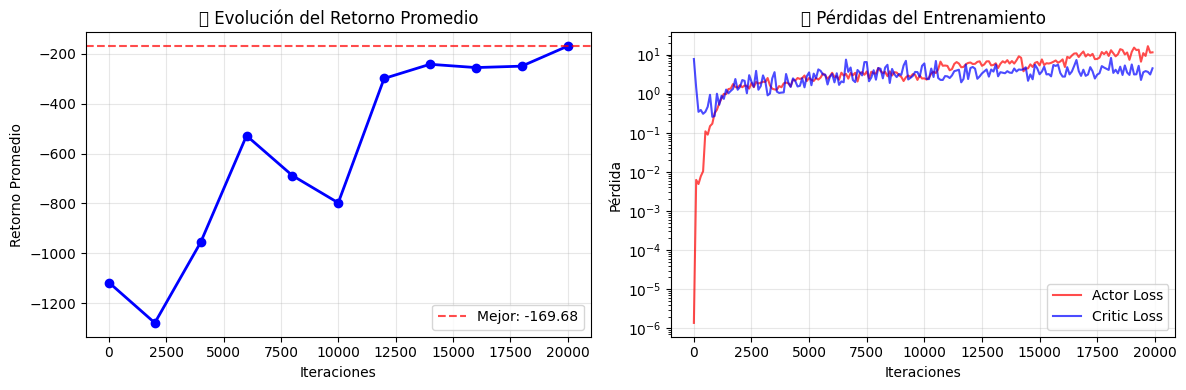

✅ Gráficas mostradas con plt.show()

📊 RESUMEN RÁPIDO
🏆 RETORNO:
   • Mejor: -169.68
   • Inicial: -1117.03
   • Final: -169.68
   • Mejora: 947.35

📈 PROGRESO:
   • Iteraciones completadas: 20,000
   • Evaluaciones realizadas: 11
   • Experiencias recolectadas: 20,602
✅ Visualización completada


In [12]:
# ===================================================================
# CELDA 11: VISUALIZACIÓN SIMPLIFICADA 
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np

print("📊 Generando visualizaciones...")

# ===================================================================
# CONFIGURACIÓN BÁSICA
# ===================================================================

# Forzar backend interactivo
%matplotlib inline
plt.ioff()  # Modo no interactivo para Jupyter

# ===================================================================
# GRÁFICA PRINCIPAL: RETORNO PROMEDIO
# ===================================================================

plt.figure(figsize=(12, 4))

# Subplot 1: Retorno a lo largo del tiempo
plt.subplot(1, 2, 1)
if len(training_metrics['average_returns']) > 0:
    plt.plot(training_metrics['evaluation_times'], 
             training_metrics['average_returns'], 
             'b-o', linewidth=2, markersize=6)
    
    plt.axhline(y=best_average_return, color='red', linestyle='--', 
                alpha=0.7, label=f'Mejor: {best_average_return:.2f}')
    
    plt.xlabel('Iteraciones')
    plt.ylabel('Retorno Promedio')
    plt.title('🏆 Evolución del Retorno Promedio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    print(f"✅ Datos del retorno: {len(training_metrics['average_returns'])} puntos")
    print(f"   Rango: {min(training_metrics['average_returns']):.1f} a {max(training_metrics['average_returns']):.1f}")

# Subplot 2: Pérdidas (simplificado)
plt.subplot(1, 2, 2)
if len(training_metrics['actor_losses']) > 0:
    # Tomar solo cada 100 puntos para evitar saturación
    step = max(1, len(training_metrics['actor_losses']) // 200)
    iterations_sample = training_metrics['iterations'][::step]
    actor_sample = training_metrics['actor_losses'][::step]
    critic_sample = training_metrics['critic_losses'][::step]
    
    plt.plot(iterations_sample, actor_sample, 'r-', alpha=0.7, label='Actor Loss')
    plt.plot(iterations_sample, critic_sample, 'b-', alpha=0.7, label='Critic Loss')
    
    plt.xlabel('Iteraciones')  
    plt.ylabel('Pérdida')
    plt.title('🧠 Pérdidas del Entrenamiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    print(f"✅ Datos de pérdidas: {len(training_metrics['actor_losses'])} puntos")

plt.tight_layout()

# ===================================================================
# MOSTRAR GRÁFICAS FORZADAMENTE
# ===================================================================

try:
    # Diferentes métodos para mostrar
    plt.show()
    print("✅ Gráficas mostradas con plt.show()")
except:
    try:
        # Método alternativo
        import IPython.display as display
        display.display(plt.gcf())
        print("✅ Gráficas mostradas con display()")
    except:
        print("⚠️ No se pudieron mostrar las gráficas automáticamente")

# Limpiar figura
plt.clf()

# ===================================================================
# RESUMEN NUMÉRICO RÁPIDO
# ===================================================================

print("\n" + "="*50)
print("📊 RESUMEN RÁPIDO")
print("="*50)

if len(training_metrics['average_returns']) > 0:
    returns = training_metrics['average_returns']
    print(f"🏆 RETORNO:")
    print(f"   • Mejor: {best_average_return:.2f}")
    print(f"   • Inicial: {returns[0]:.2f}")
    print(f"   • Final: {returns[-1]:.2f}")
    print(f"   • Mejora: {returns[-1] - returns[0]:.2f}")

print(f"\n📈 PROGRESO:")
print(f"   • Iteraciones completadas: {len(training_metrics['iterations']):,}")
print(f"   • Evaluaciones realizadas: {len(training_metrics['average_returns'])}")

if len(training_metrics['buffer_sizes']) > 0:
    print(f"   • Experiencias recolectadas: {training_metrics['buffer_sizes'][-1]:,}")

print("="*50)
print("✅ Visualización completada")

In [13]:
# ===================================================================
# CELDA 12: EVALUACIÓN COMPARATIVA - AGENTE ENTRENADO VS ALEATORIO
# ===================================================================
import time

print("🎯 EVALUACIÓN COMPARATIVA")
print("="*50)

# ===================================================================
# FUNCIÓN PARA EVALUAR POLÍTICAS
# ===================================================================
def evaluate_policy_detailed(policy, env, num_episodes=10, policy_name="Política"):
    """
    Evalúa una política y retorna métricas detalladas
    """
    total_return = 0.0
    episode_returns = []
    episode_lengths = []
    
    print(f"🔄 Evaluando {policy_name}...")
    
    for episode in range(num_episodes):
        time_step = env.reset()
        episode_return = 0.0
        episode_length = 0
        
        while not time_step.is_last():
            # Obtener acción de la política
            action_step = policy.action(time_step)
            
            # Ejecutar acción en el entorno
            time_step = env.step(action_step.action)
            
            # Acumular reward
            episode_return += time_step.reward.numpy()[0]
            episode_length += 1
        
        episode_returns.append(episode_return)
        episode_lengths.append(episode_length)
        total_return += episode_return
        
        if (episode + 1) % 5 == 0:
            print(f"   Episodio {episode + 1}/{num_episodes} - Return: {episode_return:.2f}")
    
    # Calcular estadísticas
    avg_return = total_return / num_episodes
    std_return = np.std(episode_returns)
    avg_length = np.mean(episode_lengths)
    
    return {
        'average_return': avg_return,
        'std_return': std_return,
        'episode_returns': episode_returns,
        'average_length': avg_length,
        'total_episodes': num_episodes
    }

# ===================================================================
# USAR LA POLÍTICA ALEATORIA QUE YA CREASTE
# ===================================================================
print("✅ Usando política aleatoria ya creada en celda anterior")

# ===================================================================
# EVALUACIONES COMPARATIVAS
# ===================================================================
print("\n📊 INICIANDO EVALUACIONES COMPARATIVAS")
print("-" * 40)

# Evaluar agente entrenado 
trained_results = evaluate_policy_detailed(
    policy=agent.policy,  
    env=eval_env,
    num_episodes=NUM_EVAL_EPISODES * 2,  # Más episodios para mejor estadística
    policy_name="Agente Entrenado (DDPG)"
)

# Evaluar agente aleatorio 
random_results = evaluate_policy_detailed(
    policy=random_policy,  
    env=eval_env,
    num_episodes=NUM_EVAL_EPISODES * 2,
    policy_name="Agente Aleatorio"
)

# ===================================================================
# MOSTRAR RESULTADOS COMPARATIVOS
# ===================================================================
print("\n" + "="*60)
print("🏆 RESULTADOS COMPARATIVOS")
print("="*60)

print(f"🤖 AGENTE ENTRENADO (DDPG):")
print(f"   • Retorno promedio: {trained_results['average_return']:.2f} ± {trained_results['std_return']:.2f}")
print(f"   • Longitud promedio: {trained_results['average_length']:.1f} pasos")
print(f"   • Mejor episodio: {max(trained_results['episode_returns']):.2f}")
print(f"   • Peor episodio: {min(trained_results['episode_returns']):.2f}")

print(f"\n🎲 AGENTE ALEATORIO:")
print(f"   • Retorno promedio: {random_results['average_return']:.2f} ± {random_results['std_return']:.2f}")
print(f"   • Longitud promedio: {random_results['average_length']:.1f} pasos")
print(f"   • Mejor episodio: {max(random_results['episode_returns']):.2f}")
print(f"   • Peor episodio: {min(random_results['episode_returns']):.2f}")

# Calcular mejora
improvement = trained_results['average_return'] - random_results['average_return']
improvement_percent = (improvement / abs(random_results['average_return'])) * 100

print(f"\n📈 MEJORA DEL ENTRENAMIENTO:")
print(f"   • Diferencia absoluta: {improvement:.2f}")
print(f"   • Mejora porcentual: {improvement_percent:.1f}%")

print("="*60)
print("✅ Evaluación comparativa completada")

# ===================================================================
# GUARDAR RESULTADOS PARA USAR EN VIDEOS
# ===================================================================
# Guardamos los resultados para usarlos en la siguiente celda
comparison_results = {
    'trained': trained_results,
    'random': random_results,
    'improvement': improvement,
    'improvement_percent': improvement_percent
}

print("💾 Resultados guardados para generación de videos")

🎯 EVALUACIÓN COMPARATIVA
✅ Usando política aleatoria ya creada en celda anterior

📊 INICIANDO EVALUACIONES COMPARATIVAS
----------------------------------------
🔄 Evaluando Agente Entrenado (DDPG)...
   Episodio 5/10 - Return: -465.27
   Episodio 10/10 - Return: -125.46
🔄 Evaluando Agente Aleatorio...
   Episodio 5/10 - Return: -1077.54
   Episodio 10/10 - Return: -1319.97

🏆 RESULTADOS COMPARATIVOS
🤖 AGENTE ENTRENADO (DDPG):
   • Retorno promedio: -259.93 ± 132.89
   • Longitud promedio: 200.0 pasos
   • Mejor episodio: -1.20
   • Peor episodio: -465.27

🎲 AGENTE ALEATORIO:
   • Retorno promedio: -1259.30 ± 223.74
   • Longitud promedio: 200.0 pasos
   • Mejor episodio: -968.83
   • Peor episodio: -1698.47

📈 MEJORA DEL ENTRENAMIENTO:
   • Diferencia absoluta: 999.37
   • Mejora porcentual: 79.4%
✅ Evaluación comparativa completada
💾 Resultados guardados para generación de videos


In [34]:
# ===================================================================
# CELDA 13: GENERACIÓN DE VIDEOS - AGENTE ENTRENADO VS ALEATORIO
# ===================================================================
import matplotlib.animation as animation
from matplotlib.patches import Circle, FancyBboxPatch
import matplotlib.patches as patches

print("🎬 GENERACIÓN DE VIDEOS COMPARATIVOS")
print("="*50)

# ===================================================================
# FUNCIÓN PARA RENDERIZAR EL PÉNDULO
# ===================================================================
def render_pendulum_state(ax, obs, title, color='blue'):
    """
    Renderiza el estado actual del péndulo
    
    Args:
        ax: Eje de matplotlib
        obs: Observación [cos(θ), sin(θ), θ_dot]
        title: Título del subplot
        color: Color del péndulo
    """
    ax.clear()
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    # Extraer información del estado
    cos_theta = obs[0]
    sin_theta = obs[1]
    theta_dot = obs[2]
    
    # Calcular posición del péndulo (longitud = 1)
    x = sin_theta
    y = cos_theta
    
    # Dibujar el soporte (punto fijo)
    ax.plot(0, 0, 'ko', markersize=8)
    
    # Dibujar la varilla del péndulo
    ax.plot([0, x], [0, y], color=color, linewidth=4, alpha=0.8)
    
    # Dibujar la masa del péndulo
    circle = Circle((x, y), 0.1, color=color, alpha=0.8)
    ax.add_patch(circle)
    
    # Mostrar información del estado
    angle_deg = np.arctan2(sin_theta, cos_theta) * 180 / np.pi
    ax.text(-1.4, -1.2, f'Ángulo: {angle_deg:.1f}°', fontsize=9)
    ax.text(-1.4, -1.35, f'Vel. Angular: {theta_dot:.2f}', fontsize=9)
    
    # Línea de referencia (vertical)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    
    # Objetivo (posición vertical)
    ax.plot(0, 1, 'g*', markersize=12, alpha=0.7, label='Objetivo')

# ===================================================================
# FUNCIÓN PARA EJECUTAR UN EPISODIO Y CAPTURAR FRAMES
# ===================================================================
def run_episode_with_frames(policy, env, policy_name, max_steps=200):
    """
    Ejecuta un episodio completo y captura los frames para el video
    
    Args:
        policy: Política a evaluar
        env: Entorno
        policy_name: Nombre de la política
        max_steps: Máximo número de pasos
    
    Returns:
        frames: Lista de observaciones
        actions: Lista de acciones tomadas
        rewards: Lista de recompensas
        total_reward: Recompensa total del episodio
    """
    print(f"🎥 Capturando episodio para {policy_name}...")
    
    frames = []
    actions = []
    rewards = []
    
    time_step = env.reset()
    episode_reward = 0.0
    step_count = 0
    
    while not time_step.is_last() and step_count < max_steps:
        # Guardar frame actual
        frames.append(time_step.observation.numpy()[0].copy())
        
        # Obtener acción de la política
        action_step = policy.action(time_step)
        action = action_step.action.numpy()[0]
        actions.append(action.copy())
        
        # Ejecutar acción
        time_step = env.step(action_step.action)
        
        # Guardar recompensa
        reward = time_step.reward.numpy()[0]
        rewards.append(reward)
        episode_reward += reward
        
        step_count += 1
    
    print(f"   ✅ Episodio completado: {step_count} pasos, Reward total: {episode_reward:.2f}")
    
    return frames, actions, rewards, episode_reward

# ===================================================================
# CAPTURAR EPISODIOS PARA AMBAS POLÍTICAS
# ===================================================================
print("📹 Capturando episodios para comparación...")

# Episodio del agente entrenado
trained_frames, trained_actions, trained_rewards, trained_total = run_episode_with_frames(
    policy=agent.policy,
    env=eval_env,
    policy_name="Agente Entrenado",
    max_steps=200
)

# Episodio del agente aleatorio
random_frames, random_actions, random_rewards, random_total = run_episode_with_frames(
    policy=random_policy,
    env=eval_env,
    policy_name="Agente Aleatorio",
    max_steps=200
)

print(f"📊 Comparación de episodios:")
print(f"   🤖 Agente Entrenado: {len(trained_frames)} frames, Reward: {trained_total:.2f}")
print(f"   🎲 Agente Aleatorio: {len(random_frames)} frames, Reward: {random_total:.2f}")

🎬 GENERACIÓN DE VIDEOS COMPARATIVOS
📹 Capturando episodios para comparación...
🎥 Capturando episodio para Agente Entrenado...
   ✅ Episodio completado: 200 pasos, Reward total: -470.85
🎥 Capturando episodio para Agente Aleatorio...
   ✅ Episodio completado: 200 pasos, Reward total: -855.78
📊 Comparación de episodios:
   🤖 Agente Entrenado: 200 frames, Reward: -470.85
   🎲 Agente Aleatorio: 200 frames, Reward: -855.78


In [35]:
# ===================================================================
# CELDA 14: CREACIÓN DE VIDEOS LIGEROS
# ===================================================================
print("\n🎬 Creando videos de forma eficiente...")

def create_comparison_video(trained_frames, random_frames, 
                          trained_rewards, random_rewards,
                          trained_total, random_total,
                          filename='pendulum_comparison.gif',
                          max_frames=100):  # Limitamos frames para ser más ligero
    """
    Crea un video comparativo
    """
    print(f"📹 Procesando {min(max_frames, len(trained_frames))} frames...")
    
    # Limitar número de frames para ser más eficiente
    num_frames = min(max_frames, len(trained_frames), len(random_frames))
    
    # Lista para guardar las imágenes
    images = []
    
    # Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    for i in range(0, num_frames, 2):  # Tomar cada 2do frame para ser más rápido
        # Limpiar ejes
        ax1.clear()
        ax2.clear()
        
        # Renderizar péndulo entrenado
        render_pendulum_state(
            ax1, 
            trained_frames[i], 
            f'🤖 Entrenado\nReward: {sum(trained_rewards[:i+1]):.0f}',
            color='blue'
        )
        
        # Renderizar péndulo aleatorio
        render_pendulum_state(
            ax2, 
            random_frames[i], 
            f'🎲 Aleatorio\nReward: {sum(random_rewards[:i+1]):.0f}',
            color='red'
        )
        
        # Título general
        fig.suptitle(f'Paso {i+1} - Entrenado: {trained_total:.0f} vs Aleatorio: {random_total:.0f}')
        
        # Convertir a imagen
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        
        # Mostrar progreso cada 20 frames
        if (i + 1) % 20 == 0:
            print(f"   Procesado frame {i+1}/{num_frames}")
    
    plt.close(fig)  # Cerrar figura para liberar memoria
    
    # Guardar como GIF
    print(f"💾 Guardando video como {filename}...")
    imageio.mimsave(filename, images, duration=0.1)  # 0.1s por frame
    print(f"✅ Video guardado: {filename}")
    return filename

# Crear el video comparativo
video_file = create_comparison_video(
    trained_frames, random_frames,
    trained_rewards, random_rewards, 
    trained_total, random_total,
    filename='pendulum_comparison.gif',
    max_frames=100  # Cambiar de 50 a 100 frames
)

print(f"\n🎉 Video creado exitosamente: {video_file}")
print("📁 El archivo se guardó en el directorio de trabajo de Kaggle")


🎬 Creando videos de forma eficiente...
📹 Procesando 100 frames...
💾 Guardando video como pendulum_comparison.gif...
✅ Video guardado: pendulum_comparison.gif

🎉 Video creado exitosamente: pendulum_comparison.gif
📁 El archivo se guardó en el directorio de trabajo de Kaggle


📺 VISUALIZACIÓN DE VIDEOS
✅ Video encontrado!
📏 Tamaño del archivo: 485464 bytes

🎬 Reproduciendo video comparativo:


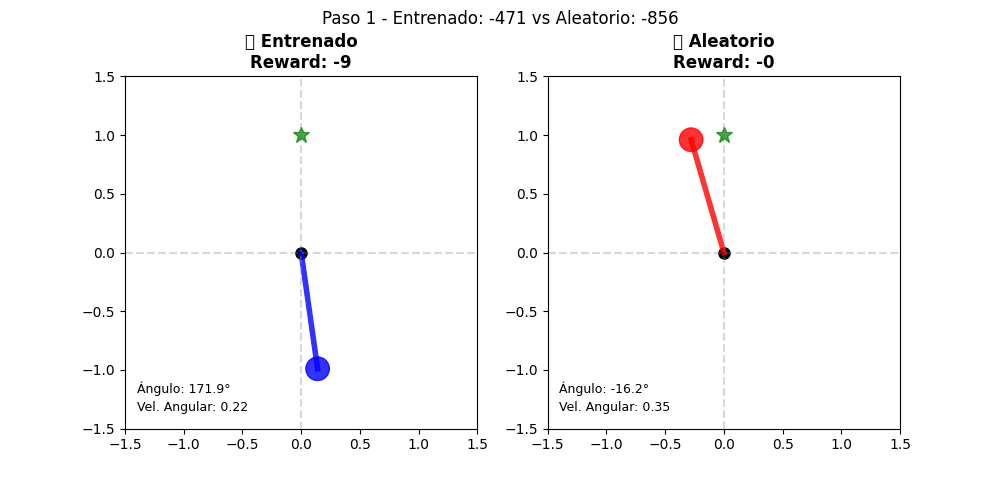


📁 Archivos en el directorio actual:
   🎬 pendulum_comparison.gif


In [36]:
# ===================================================================
# CELDA 15: VISUALIZACIÓN DE VIDEOS EN EL NOTEBOOK
# ===================================================================
from IPython.display import Image, display
import os

print("📺 VISUALIZACIÓN DE VIDEOS")
print("="*40)

# Verificar que el archivo existe
if os.path.exists('pendulum_comparison.gif'):
    print("✅ Video encontrado!")
    print(f"📏 Tamaño del archivo: {os.path.getsize('pendulum_comparison.gif')} bytes")
    
    # Mostrar el GIF directamente en el notebook
    print("\n🎬 Reproduciendo video comparativo:")
    display(Image('pendulum_comparison.gif'))
    
else:
    print("❌ Video no encontrado")

# También mostrar información del archivo
print(f"\n📁 Archivos en el directorio actual:")
for file in os.listdir('.'):
    if file.endswith('.gif'):
        print(f"   🎬 {file}")